In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import time

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from imblearn.over_sampling import SMOTE

breast_cancer_wisconsin_original = fetch_ucirepo(id=15)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

data = X.copy()
data['Class'] = y['Class']
data['Class_binary'] = data['Class'].apply(lambda x: 0 if x == 2 else 1) 

In [3]:
print("\n=== Data ===")
distribution_data = len(data)
print(f"distribution: {distribution_data}")


=== Data ===
distribution: 699


# Preprocessing

In [4]:
print("\n=== Duplicates ===")
duplicates = data.duplicated().sum()
print(f"Number of duplicated rows: {duplicates}")

data.drop_duplicates(inplace=True)


=== Duplicates ===
Number of duplicated rows: 236


In [5]:
print("\n=== Data ===")
distribution_data = len(data)
print(f"distribution: {distribution_data}")


=== Data ===
distribution: 463


In [3]:
print("\n=== Missing Values ===")
missing = data.isnull().sum()
missing_pct = (missing / len(data) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

for col in ['Bare_nuclei']:
    for target_class in data['Class_binary'].unique():
        mode_value = data.loc[data['Class_binary'] == target_class, col].mode()[0]
        data.loc[(data['Class_binary'] == target_class) & (data[col].isnull()), col] = mode_value


=== Missing Values ===
             Missing Count  Missing %
Bare_nuclei             14       3.02


In [4]:
numerical_cols = ['Clump_thickness', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape', 
                  'Marginal_adhesion', 'Single_epithelial_cell_size', 'Bare_nuclei', 
                  'Bland_chromatin', 'Normal_nucleoli', 'Mitoses']

for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

In [5]:
# Tidak ada fitur kategorikal yang perlu diencode sebagai dummy variables karena semua fitur adalah numerik

In [ ]:
X_processed = data.drop(['Class', 'Class_binary'], axis=1)
y_processed = data['Class_binary']

print("Distribusi kelas:\n", y_processed.value_counts())

Distribusi kelas:
 Class_binary
1    238
0    225
Name: count, dtype: int64


# Modeling


=== RLA Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0139 detik
Waktu Prediksi (Training Set): 0.4492 detik
Waktu Prediksi (Testing Set): 0.0685 detik

Reflex Zones Defined (Automated):
Clump_thickness: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Uniformity_of_cell_size: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Uniformity_of_cell_shape: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Marginal_adhesion: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Single_epithelial_cell_size: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Bare_nuclei: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Bland_chromatin: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Normal_nucleoli: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Mitoses: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'

Training Performance:
Accuracy: 0.9008
Precision: 0.9267
Recall: 0.8762
F1-Score: 0.9008
ROC AUC: 0.9227

Classification Report (Training):
              precision    recall  f1-score   

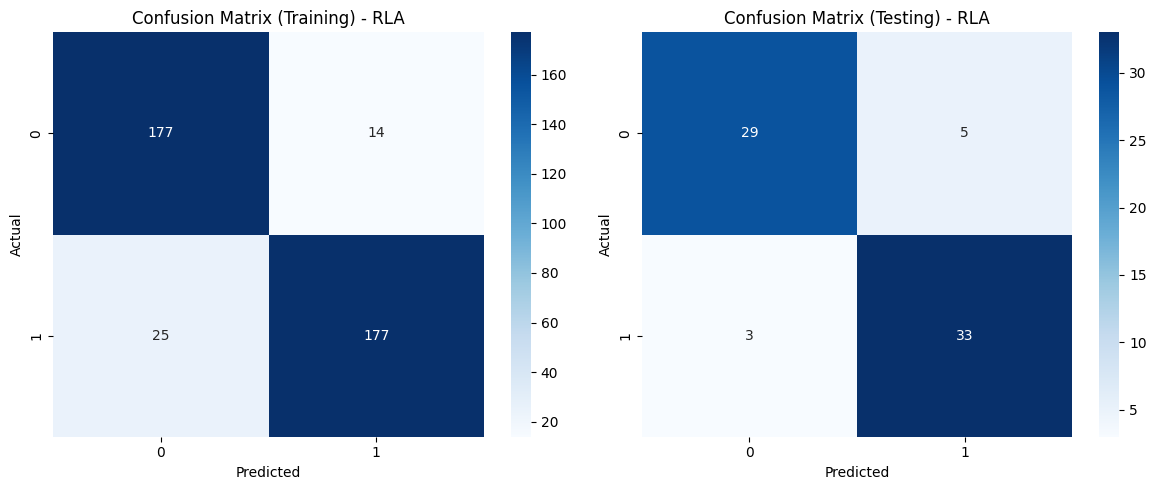

In [ ]:
def define_reflex_zones_automated(X, y, corr_threshold=0.15, prop_threshold=0.35, odds_ratio_threshold=1.5, class_weight=1.0):
    reflex_zones = {}
    correlations = X.corrwith(y)
    class_weighted_corr = correlations * (y.mean() * class_weight + (1 - y.mean()) * (1 - class_weight))

    numeric_features = ['Clump_thickness', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape', 
                        'Marginal_adhesion', 'Single_epithelial_cell_size', 'Bare_nuclei', 
                        'Bland_chromatin', 'Normal_nucleoli', 'Mitoses']
    for feature in numeric_features:
        if abs(class_weighted_corr[feature]) > corr_threshold:
            if class_weighted_corr[feature] > 0:
                threshold = X[feature].quantile(0.75)
                reflex_zones[feature] = lambda x, t=threshold: x > t
            else:
                threshold = X[feature].quantile(0.25)
                reflex_zones[feature] = lambda x, t=threshold: x < t

    categorical_features = [col for col in X.columns if col not in numeric_features]
    for feature in categorical_features:
        if abs(class_weighted_corr[feature]) > corr_threshold:
            prop_class_1 = X.loc[y == 1, feature].mean()
            prop_class_0 = X.loc[y == 0, feature].mean()
            odds_1 = prop_class_1 / (1 - prop_class_1 + 1e-10)
            odds_0 = prop_class_0 / (1 - prop_class_0 + 1e-10)
            odds_ratio = odds_1 / (odds_0 + 1e-10)
            if prop_class_1 > prop_threshold and odds_ratio > odds_ratio_threshold:
                reflex_zones[feature] = lambda x: x == 1

    if not reflex_zones:
        corr_threshold = max(0.10, corr_threshold - 0.05)
        prop_threshold = max(0.25, prop_threshold - 0.05)
        odds_ratio_threshold = max(1.0, odds_ratio_threshold - 0.2)
        for feature in numeric_features:
            if abs(correlations[feature]) > corr_threshold:
                if correlations[feature] > 0:
                    threshold = X[feature].quantile(0.75)
                    reflex_zones[feature] = lambda x, t=threshold: x > t
                else:
                    threshold = X[feature].quantile(0.25)
                    reflex_zones[feature] = lambda x, t=threshold: x < t
        for feature in categorical_features:
            if abs(correlations[feature]) > corr_threshold:
                prop_class_1 = X.loc[y == 1, feature].mean()
                prop_class_0 = X.loc[y == 0, feature].mean()
                odds_1 = prop_class_1 / (1 - prop_class_1 + 1e-10)
                odds_0 = prop_class_0 / (1 - prop_class_0 + 1e-10)
                odds_ratio = odds_1 / (odds_0 + 1e-10)
                if prop_class_1 > prop_threshold and odds_ratio > odds_ratio_threshold:
                    reflex_zones[feature] = lambda x: x == 1

    if not reflex_zones:
        raise ValueError("No reflex zones defined even with loosened thresholds. Check data distribution.")
    return reflex_zones

class ReflexLearningAlgorithm(BaseEstimator, ClassifierMixin):
    def __init__(self, reflex_zones=None, threshold_score=3.0, key_zones=None, key_weight=1.0, min_activation=1):
        self.reflex_zones = reflex_zones
        self.threshold_score = threshold_score
        self.key_zones = key_zones if key_zones is not None else []
        self.key_weight = key_weight
        self.min_activation = min_activation
    
    def fit(self, X, y=None):
        if self.reflex_zones is None:
            self.reflex_zones = define_reflex_zones_automated(X, y)
        self.reflex_zones_ = self.reflex_zones
        return self
    
    def predict(self, X):
        predictions = []
        scores = []
        for i in range(X.shape[0]):
            base_score = sum(1 for feature, condition in self.reflex_zones.items() 
                             if condition(X.iloc[i][feature]))
            key_score = sum(1 for feature, condition in self.reflex_zones.items()
                            if feature in self.key_zones and condition(X.iloc[i][feature])) * self.key_weight
            total_score = base_score + key_score
            active_zones = sum(1 for feature, condition in self.reflex_zones.items() 
                               if condition(X.iloc[i][feature]))
            adjusted_threshold = self.threshold_score - (self.key_weight * 0.4 if active_zones >= self.min_activation else 0)
            scores.append(total_score)
            if total_score >= adjusted_threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        self.scores_ = np.array(scores) 
        return np.array(predictions)
    
    def get_params(self, deep=True):
        return {'reflex_zones': self.reflex_zones, 'threshold_score': self.threshold_score, 'key_zones': self.key_zones, 'key_weight': self.key_weight, 'min_activation': self.min_activation}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

def evaluate_rla(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_train = model.predict(X_train)
    train_pred_time = time.perf_counter() - start_time
    y_score_train = model.scores_

    start_time = time.perf_counter()
    y_pred_test = model.predict(X_test)
    test_pred_time = time.perf_counter() - start_time
    y_score_test = model.scores_
    
    print(f"\n=== {model_name} Baseline Model Evaluation ===")
    print(f"\nWaktu Komputasi:")
    print(f"Waktu Pelatihan: {training_time:.4f} detik")
    print(f"Waktu Prediksi (Training Set): {train_pred_time:.4f} detik")
    print(f"Waktu Prediksi (Testing Set): {test_pred_time:.4f} detik")

    print("\nReflex Zones Defined (Automated):")
    for feature, condition in model.reflex_zones_.items():
        print(f"{feature}: {condition.__code__.co_code}")

    roc_auc_train = roc_auc_score(y_train, y_score_train)
    roc_auc_test = roc_auc_score(y_test, y_score_test)

    print("\nTraining Performance:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
    print(f"ROC AUC: {roc_auc_train:.4f}")
    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_pred_train))

    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
    print(f"ROC AUC: {roc_auc_test:.4f}")
    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    cv_scores_acc = cross_val_score(model, X_processed, y_processed, cv=5, scoring='accuracy')

    print("\nCross-Validation (5-Fold) Accuracy:")
    print(f"Scores: {cv_scores_acc.round(4)}")
    print(f"Mean Accuracy: {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std():.4f}")

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Training) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Testing) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.15, random_state=42, stratify=y_processed
)

rla = ReflexLearningAlgorithm(threshold_score=1.0)
evaluate_rla(rla, X_train, X_test, y_train, y_test, model_name="RLA")

# Pembanding

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_train = model.predict(X_train)
    train_pred_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_test = model.predict(X_test)
    test_pred_time = time.perf_counter() - start_time
    
    print(f"\n=== {model_name} Baseline Model Evaluation ===")
    print(f"\nWaktu Komputasi:")
    print(f"Waktu Pelatihan: {training_time:.4f} detik")
    print(f"Waktu Prediksi (Training Set): {train_pred_time:.4f} detik")
    print(f"Waktu Prediksi (Testing Set): {test_pred_time:.4f} detik")

    print("\nTraining Performance:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_pred_train))

    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    cv_scores = cross_val_score(model, X_processed, y_processed, cv=5, scoring='accuracy')
    print("\nCross-Validation (5-Fold) Accuracy:")
    print(f"Scores: {cv_scores.round(4)}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Training) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Testing) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = model.decision_function(X_train)
        y_pred_proba_test = model.decision_function(X_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label='Train Precision-Recall')
    plt.plot(recall_test, precision_test, label='Test Precision-Recall')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_processed, y_processed, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')
    plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                     train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1),
                     test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.1)
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
        print(f"\nFeature Importance ({model_name}):")
        for feature, importance in feature_importance.sort_values(ascending=False).items():
            print(f"{feature}: {importance:.4f}")
        plt.figure(figsize=(10, 6))
        feature_importance.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
    elif hasattr(model, 'coef_'):
        feature_coefficients = pd.Series(model.coef_[0], index=X_train.columns)
        print(f"\nFeature Coefficients ({model_name}):")
        for feature, coef in feature_coefficients.sort_values(ascending=False).items():
            print(f"{feature}: {coef:.4f}")
        plt.figure(figsize=(10, 6))
        feature_coefficients.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Feature Coefficients - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Coefficient')
        plt.tight_layout()
        plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.15, random_state=42, stratify=y_processed
)


=== Decision Tree Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0087 detik
Waktu Prediksi (Training Set): 0.0027 detik
Waktu Prediksi (Testing Set): 0.0018 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       202

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393


Testing Performance:
Accuracy: 0.8714
Precision: 0.8462
Recall: 0.9167
F1-Score: 0.8800

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        34
           1       0.85      0.92      0.88        36

    accuracy                           0.87        70
   macro avg       0.87

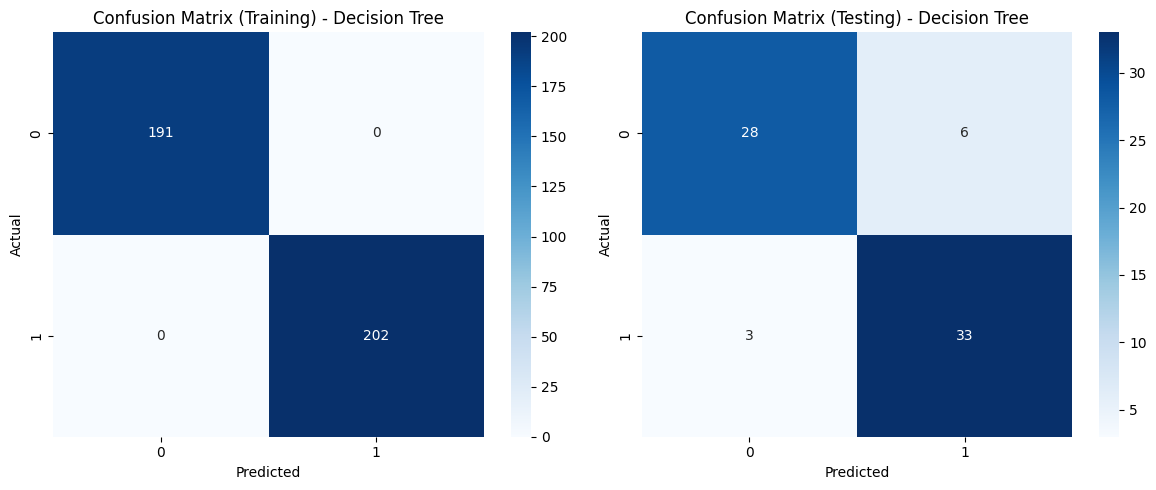

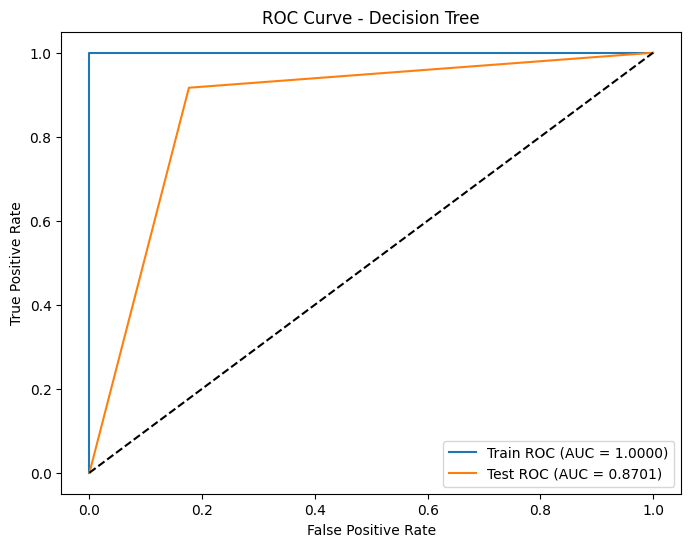

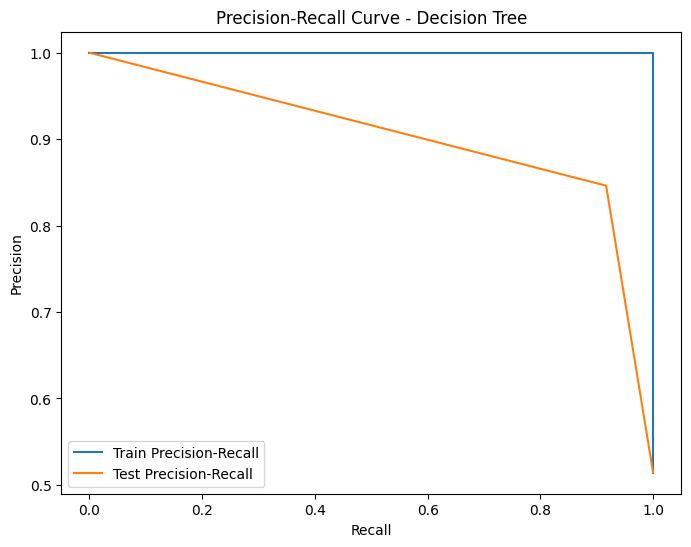

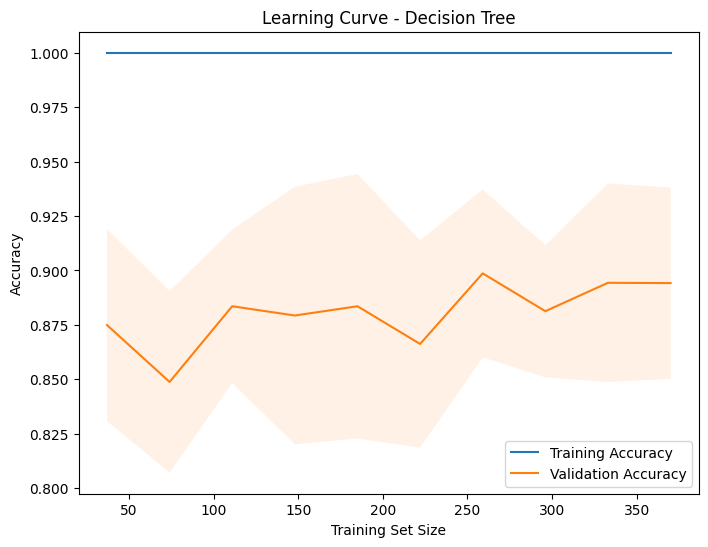


Feature Importance (Decision Tree):
Uniformity_of_cell_size: 0.6734
Bare_nuclei: 0.1795
Normal_nucleoli: 0.0529
Clump_thickness: 0.0321
Uniformity_of_cell_shape: 0.0231
Marginal_adhesion: 0.0195
Bland_chromatin: 0.0102
Mitoses: 0.0093
Single_epithelial_cell_size: 0.0000


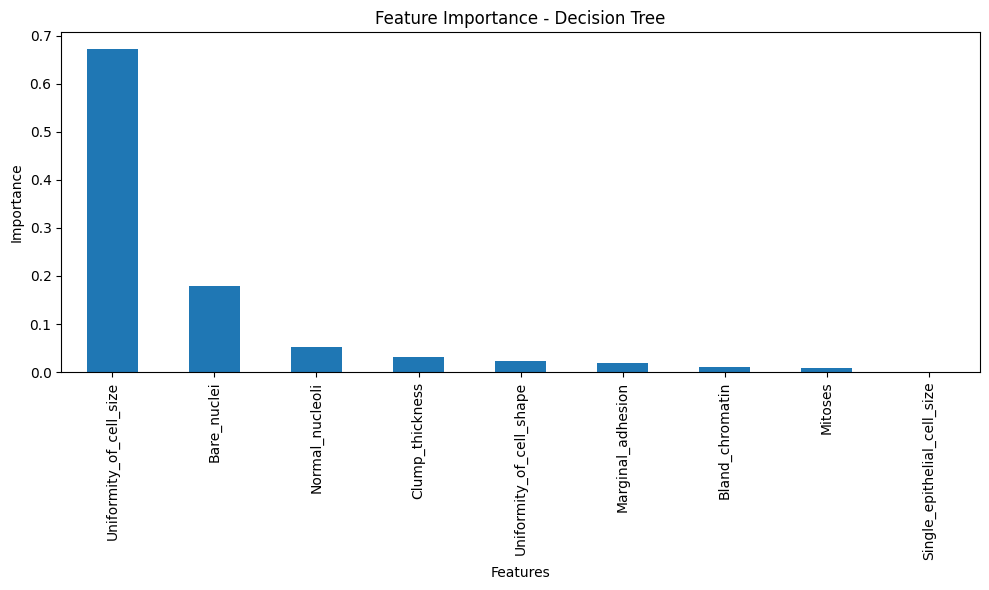

In [9]:
# --- Decision Tree Baseline ---
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, X_train, X_test, y_train, y_test, 'Decision Tree')


=== Logistic Regression Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0133 detik
Waktu Prediksi (Training Set): 0.0017 detik
Waktu Prediksi (Testing Set): 0.0011 detik

Training Performance:
Accuracy: 0.9567
Precision: 0.9602
Recall: 0.9554
F1-Score: 0.9578

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       191
           1       0.96      0.96      0.96       202

    accuracy                           0.96       393
   macro avg       0.96      0.96      0.96       393
weighted avg       0.96      0.96      0.96       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg     

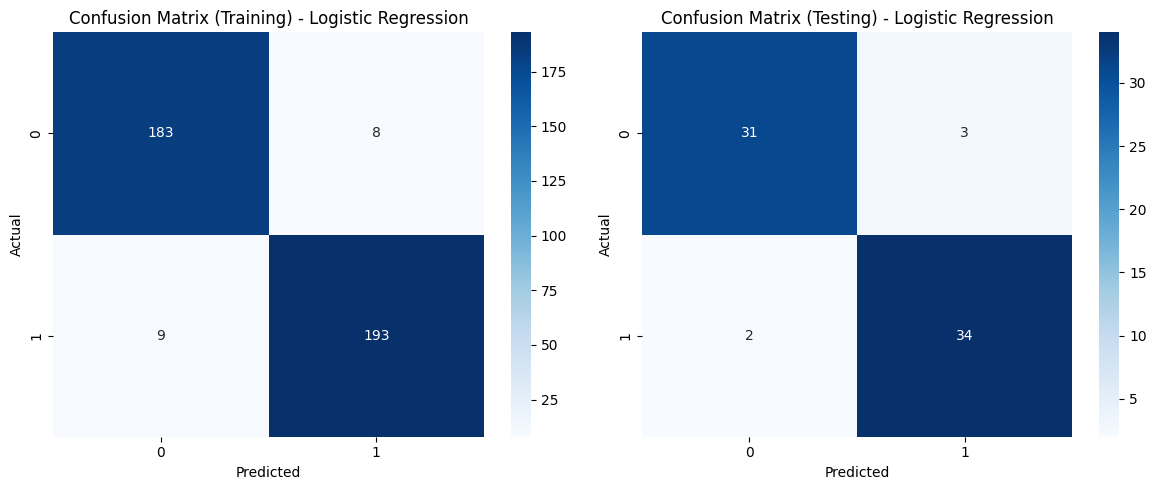

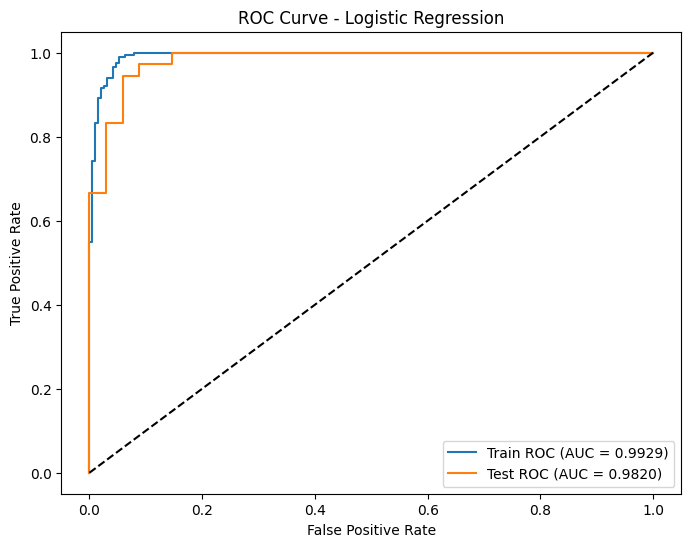

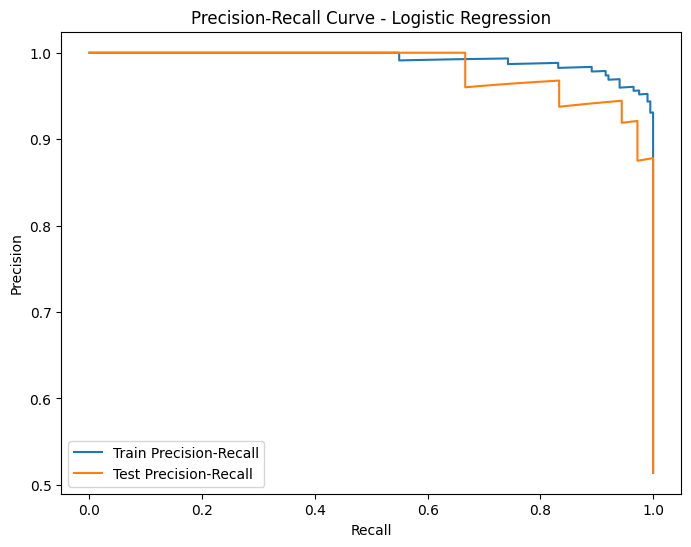

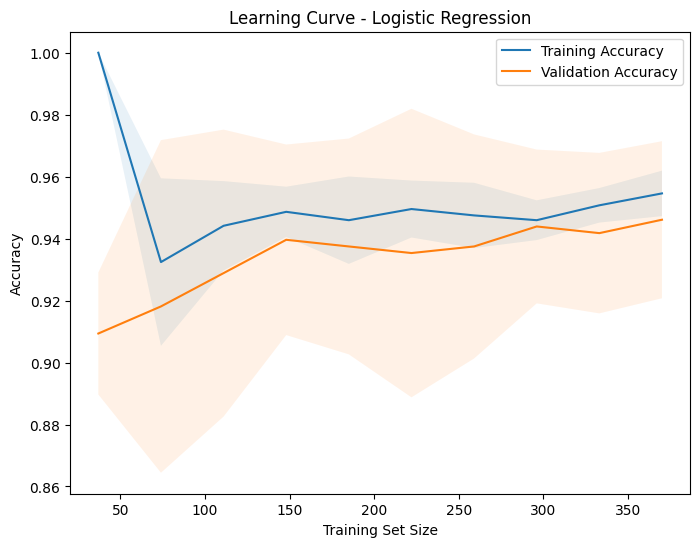


Feature Coefficients (Logistic Regression):
Mitoses: 1.0135
Clump_thickness: 0.4913
Bare_nuclei: 0.4908
Marginal_adhesion: 0.2627
Bland_chromatin: 0.2463
Uniformity_of_cell_shape: 0.2123
Single_epithelial_cell_size: 0.1920
Normal_nucleoli: 0.1267
Uniformity_of_cell_size: 0.0822


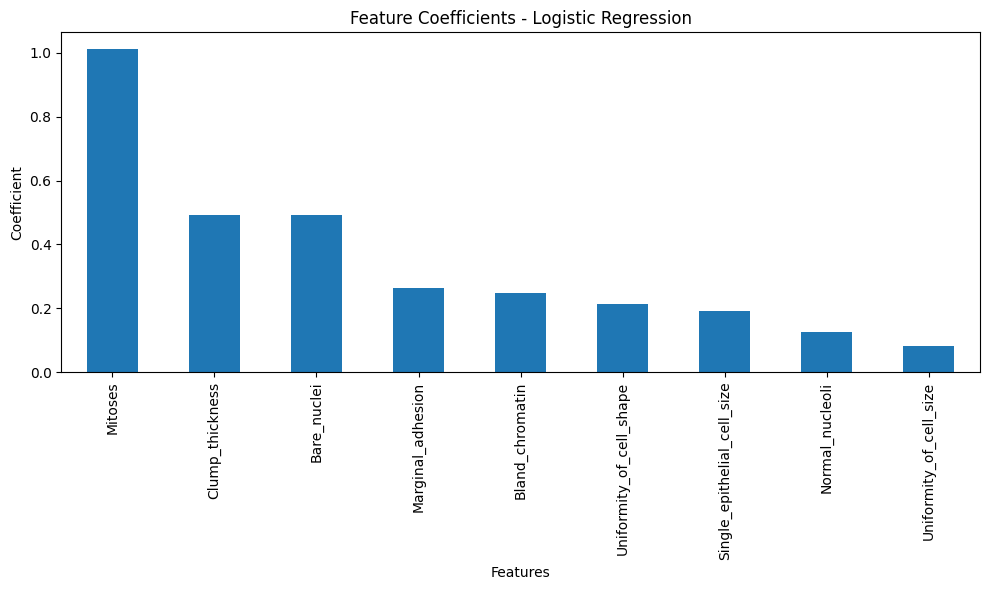

In [10]:
# --- Logistic Regression Baseline ---
lr_model = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model, X_train, X_test, y_train, y_test, 'Logistic Regression')


=== k-Nearest Neighbors Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0099 detik
Waktu Prediksi (Training Set): 0.0225 detik
Waktu Prediksi (Testing Set): 0.0070 detik

Training Performance:
Accuracy: 0.9695
Precision: 0.9567
Recall: 0.9851
F1-Score: 0.9707

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       191
           1       0.96      0.99      0.97       202

    accuracy                           0.97       393
   macro avg       0.97      0.97      0.97       393
weighted avg       0.97      0.97      0.97       393


Testing Performance:
Accuracy: 0.9429
Precision: 0.9444
Recall: 0.9444
F1-Score: 0.9444

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.94      0.94      0.94        36

    accuracy                           0.94        70
   macro avg     

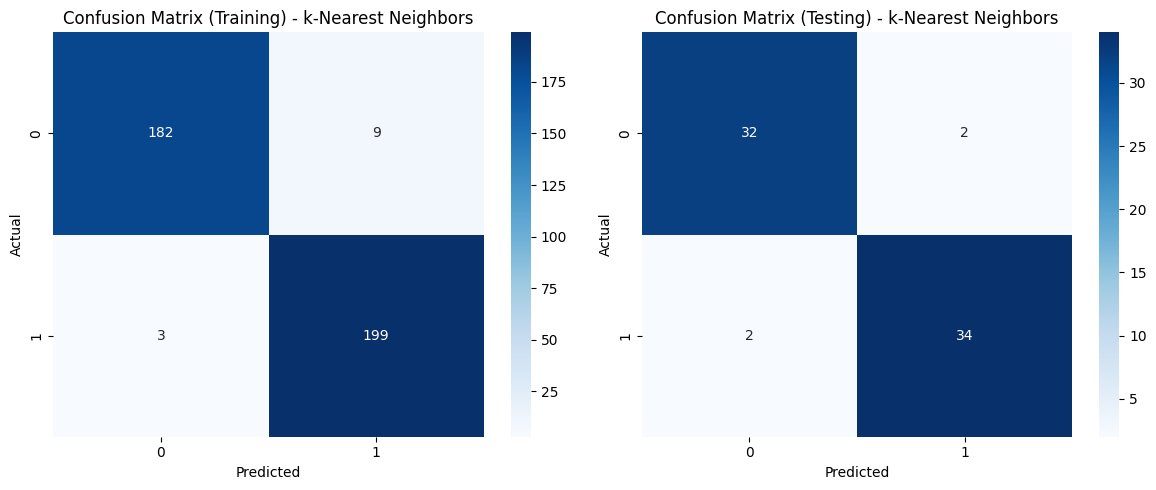

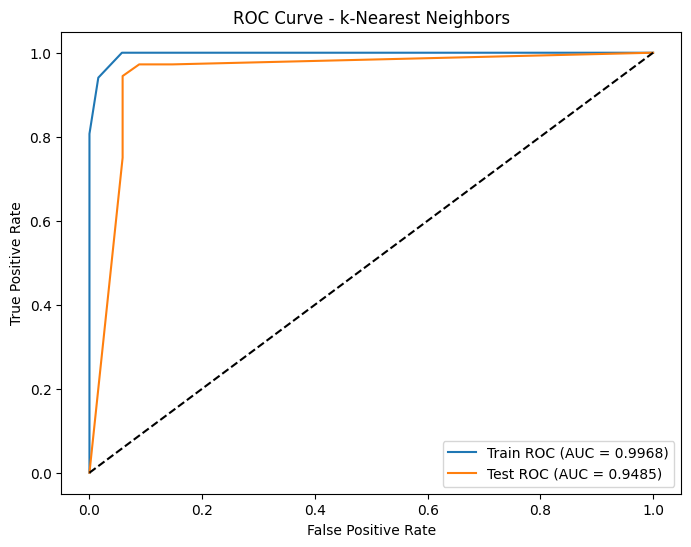

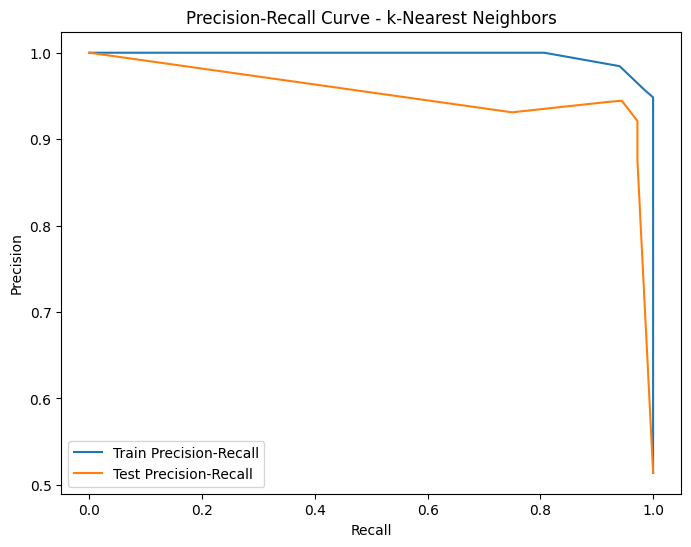

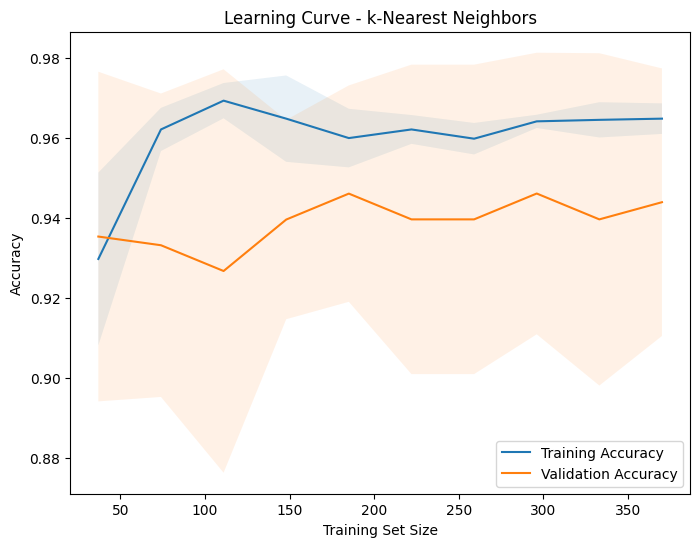

In [11]:
# --- k-Nearest Neighbors Baseline ---
knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, X_test, y_train, y_test, 'k-Nearest Neighbors')


=== Naive Bayes Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0036 detik
Waktu Prediksi (Training Set): 0.0018 detik
Waktu Prediksi (Testing Set): 0.0014 detik

Training Performance:
Accuracy: 0.9517
Precision: 0.9296
Recall: 0.9802
F1-Score: 0.9542

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       191
           1       0.93      0.98      0.95       202

    accuracy                           0.95       393
   macro avg       0.95      0.95      0.95       393
weighted avg       0.95      0.95      0.95       393


Testing Performance:
Accuracy: 0.9143
Precision: 0.8947
Recall: 0.9444
F1-Score: 0.9189

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        34
           1       0.89      0.94      0.92        36

    accuracy                           0.91        70
   macro avg       0.92  

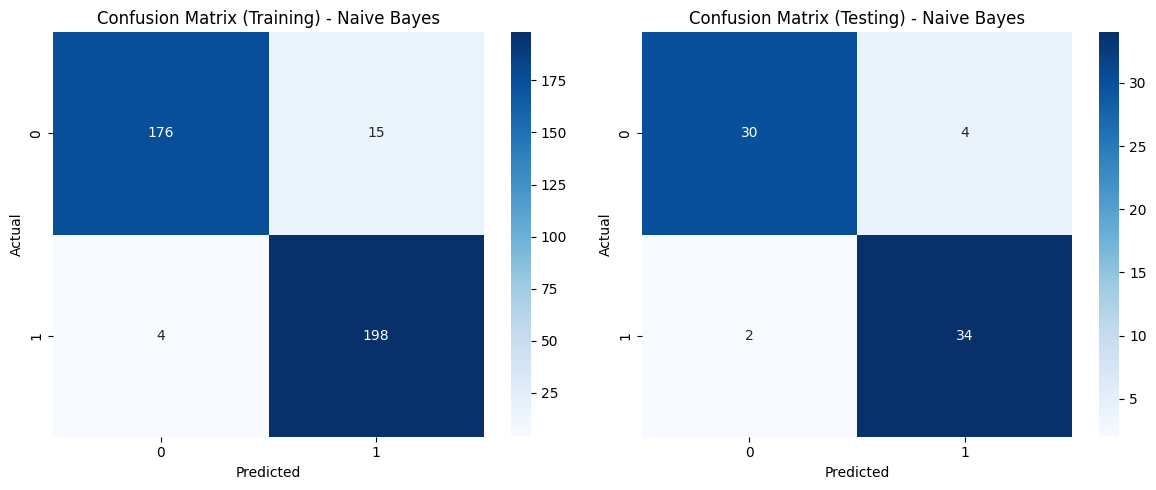

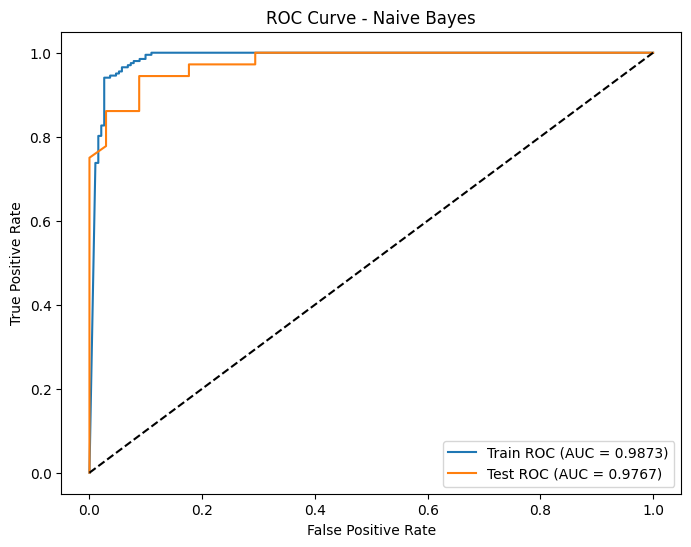

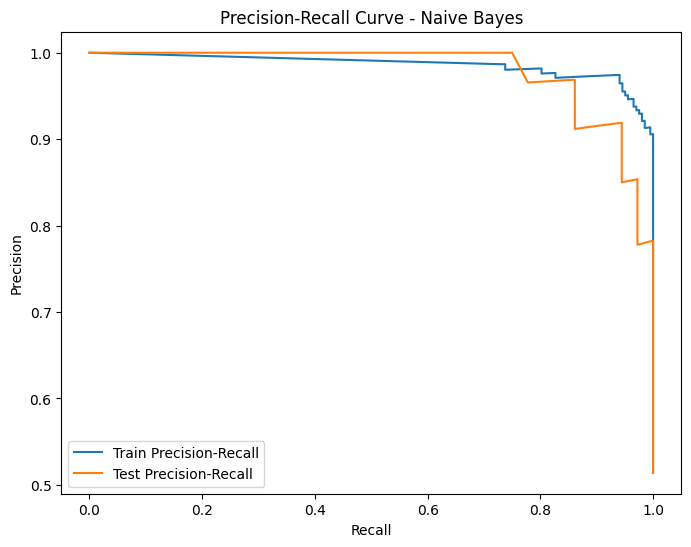

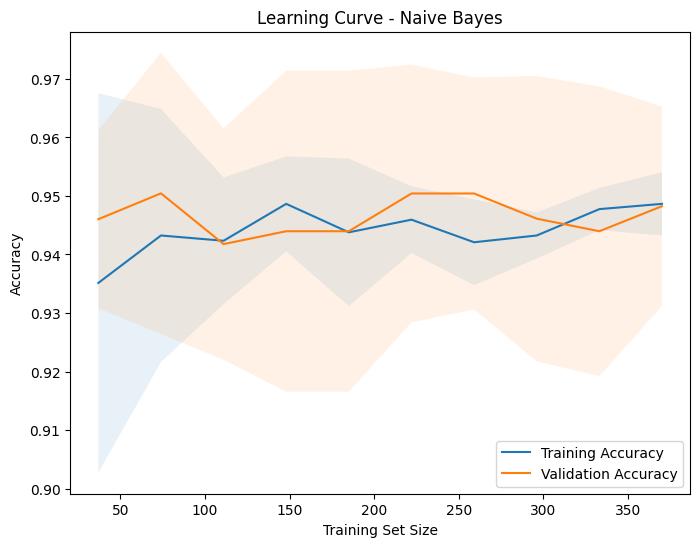

In [12]:
# --- Naive Bayes Baseline ---
nb_model = GaussianNB()
evaluate_model(nb_model, X_train, X_test, y_train, y_test, 'Naive Bayes')


=== Support Vector Machine Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0202 detik
Waktu Prediksi (Training Set): 0.0064 detik
Waktu Prediksi (Testing Set): 0.0028 detik

Training Performance:
Accuracy: 0.9644
Precision: 0.9476
Recall: 0.9851
F1-Score: 0.9660

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       191
           1       0.95      0.99      0.97       202

    accuracy                           0.96       393
   macro avg       0.97      0.96      0.96       393
weighted avg       0.97      0.96      0.96       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg  

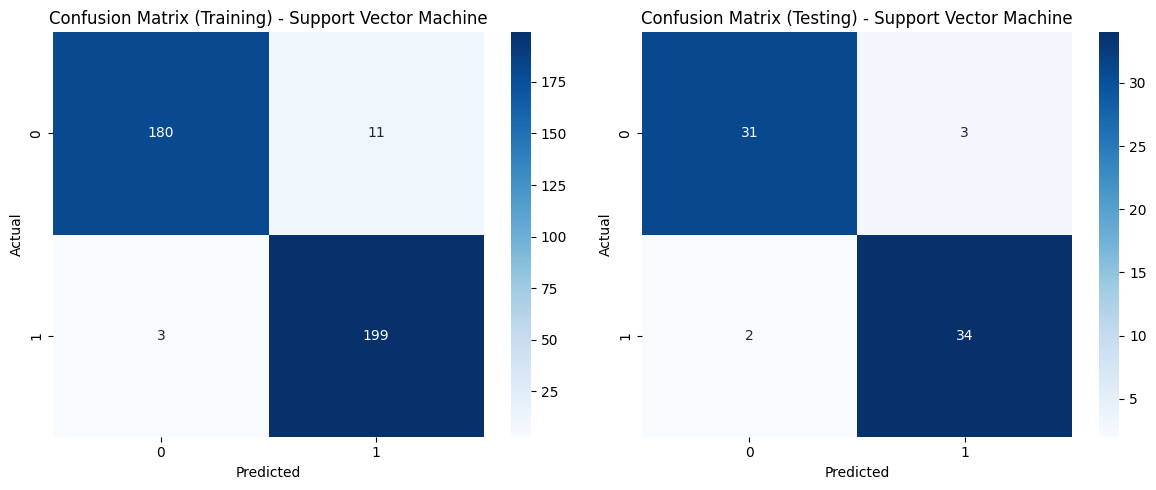

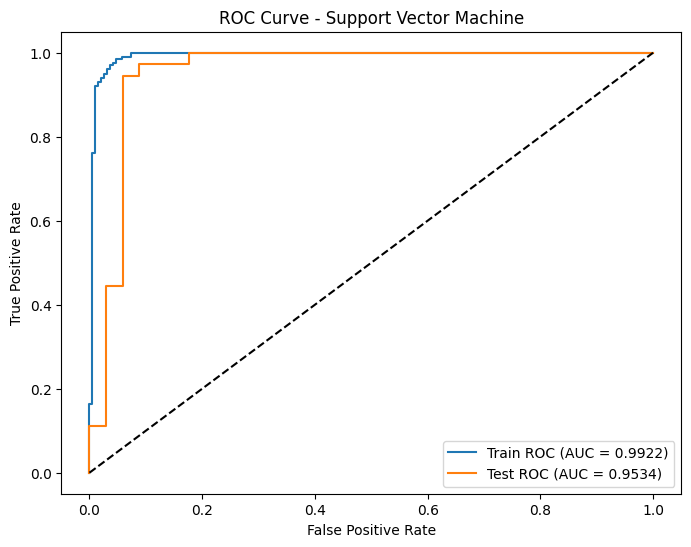

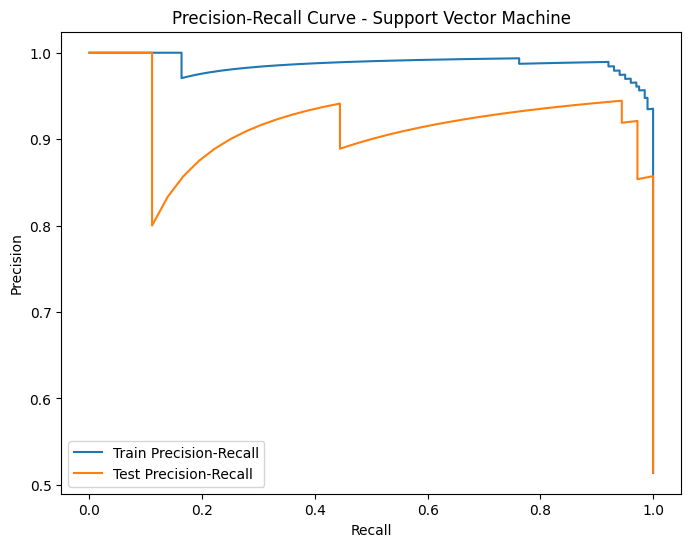

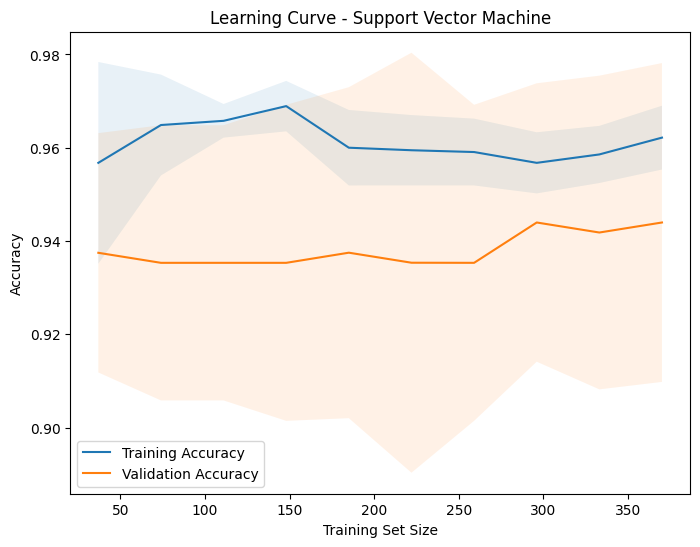

In [13]:
# --- Support Vector Machine Baseline ---
svm_model = SVC(probability=True, random_state=42)
evaluate_model(svm_model, X_train, X_test, y_train, y_test, 'Support Vector Machine')


=== Random Forest Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1627 detik
Waktu Prediksi (Training Set): 0.0108 detik
Waktu Prediksi (Testing Set): 0.0084 detik

Training Performance:
Accuracy: 0.9975
Precision: 0.9951
Recall: 1.0000
F1-Score: 0.9975

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       191
           1       1.00      1.00      1.00       202

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg       0.93

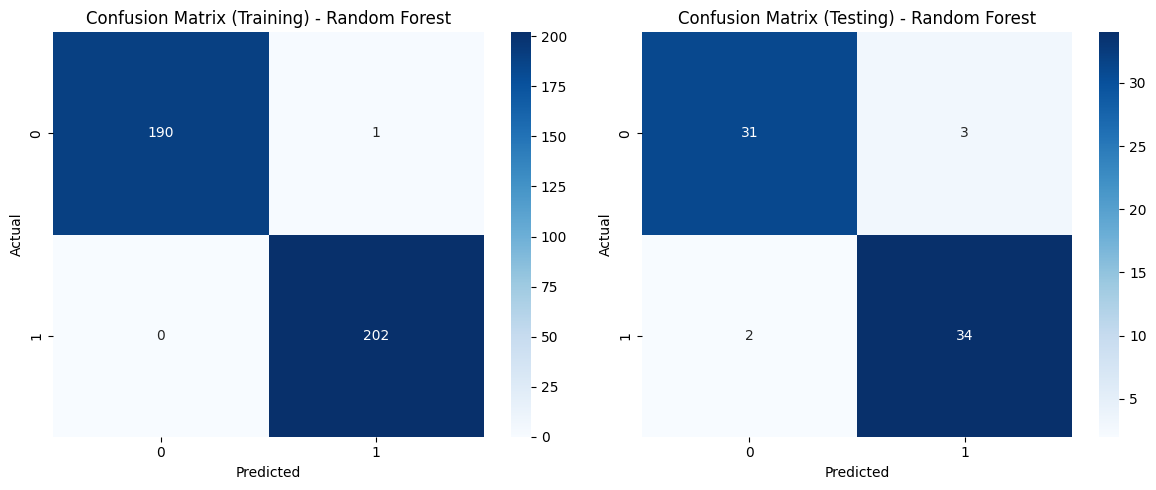

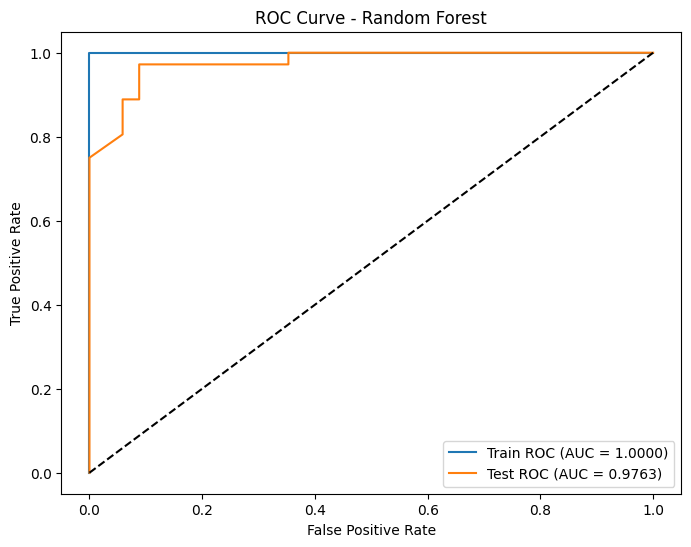

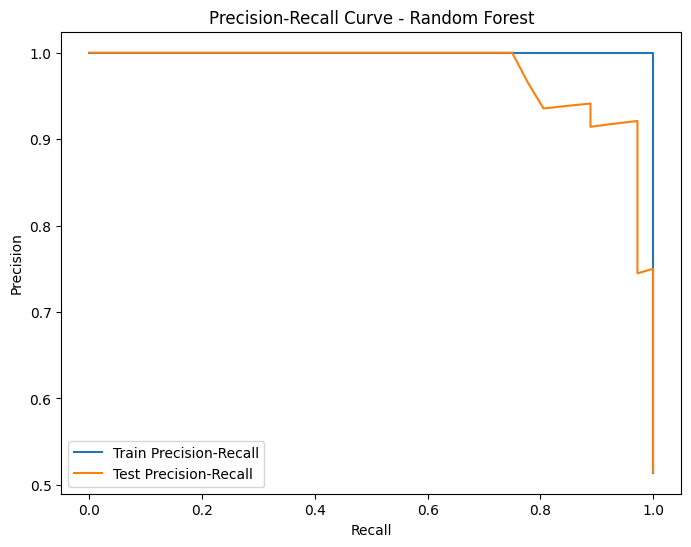

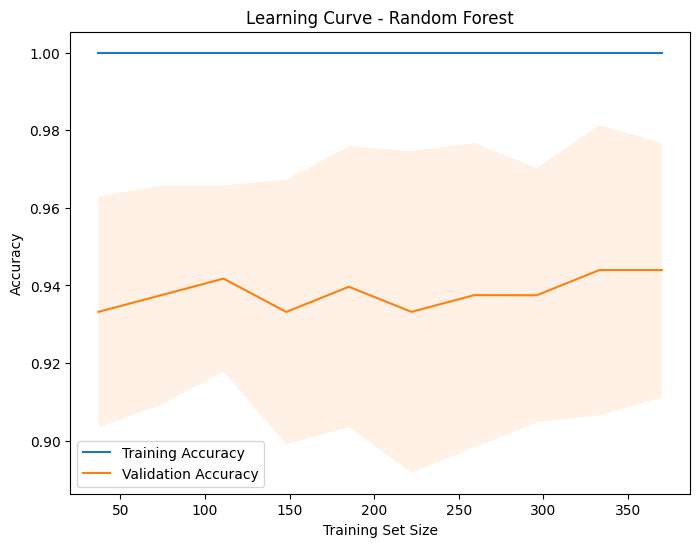


Feature Importance (Random Forest):
Uniformity_of_cell_size: 0.3107
Uniformity_of_cell_shape: 0.1913
Bare_nuclei: 0.1907
Bland_chromatin: 0.0846
Clump_thickness: 0.0762
Normal_nucleoli: 0.0586
Single_epithelial_cell_size: 0.0516
Marginal_adhesion: 0.0276
Mitoses: 0.0088


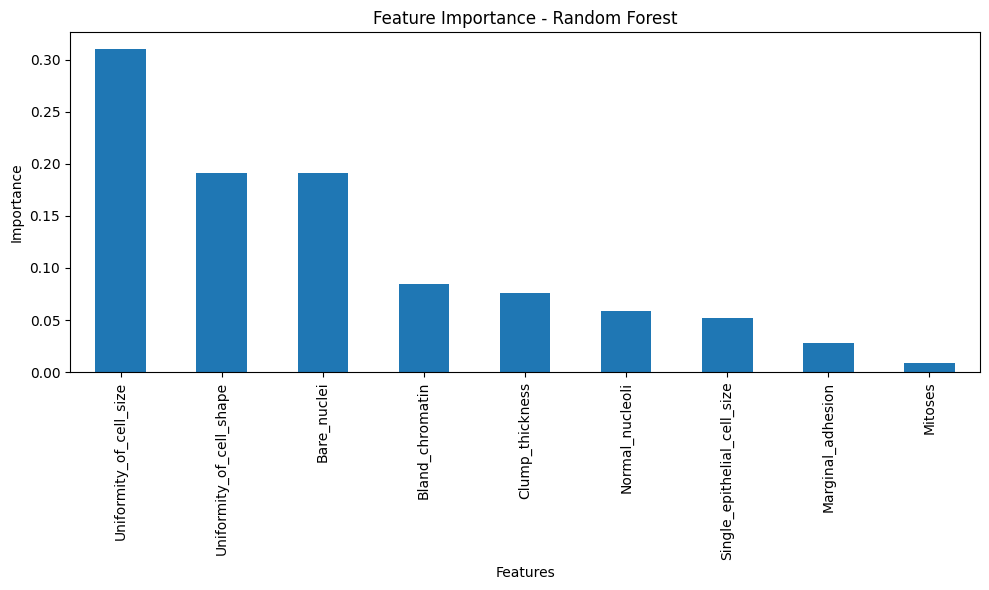

In [14]:
# --- Random Forest Baseline ---
rf_model = RandomForestClassifier(random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')


=== Gradient Boosting Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1779 detik
Waktu Prediksi (Training Set): 0.0024 detik
Waktu Prediksi (Testing Set): 0.0015 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       202

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg       

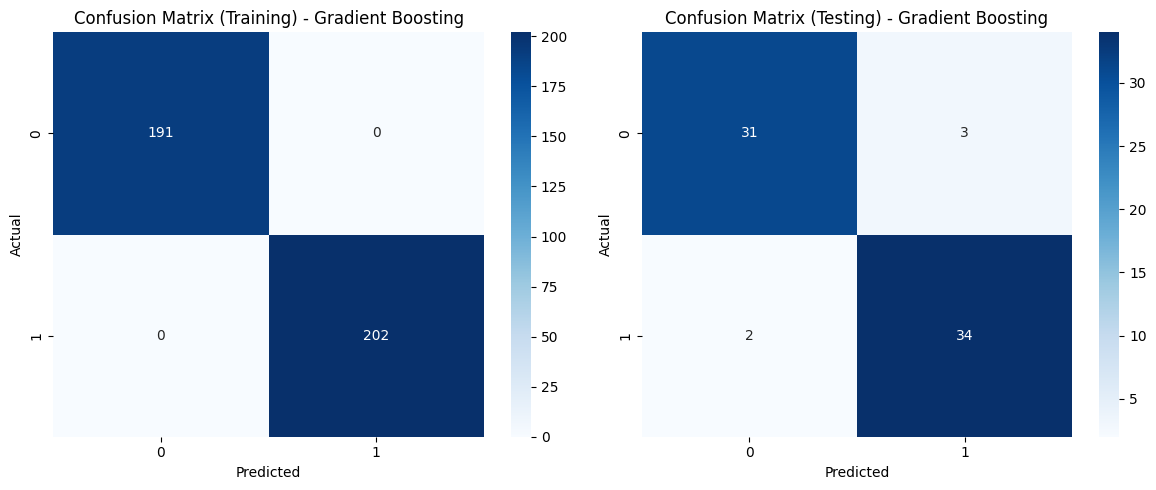

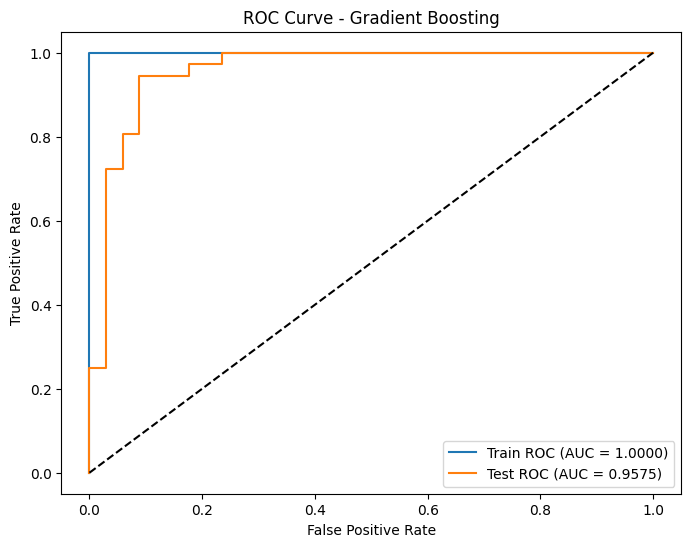

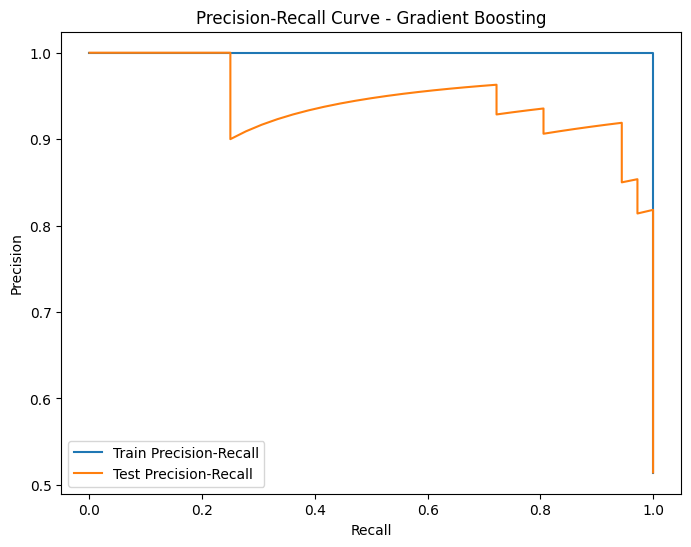

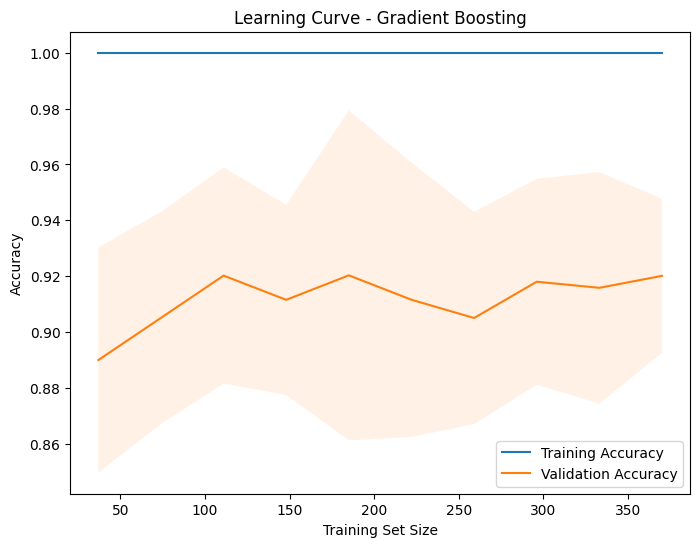


Feature Importance (Gradient Boosting):
Uniformity_of_cell_size: 0.6613
Bare_nuclei: 0.1897
Clump_thickness: 0.0707
Uniformity_of_cell_shape: 0.0238
Normal_nucleoli: 0.0214
Marginal_adhesion: 0.0145
Single_epithelial_cell_size: 0.0080
Bland_chromatin: 0.0053
Mitoses: 0.0052


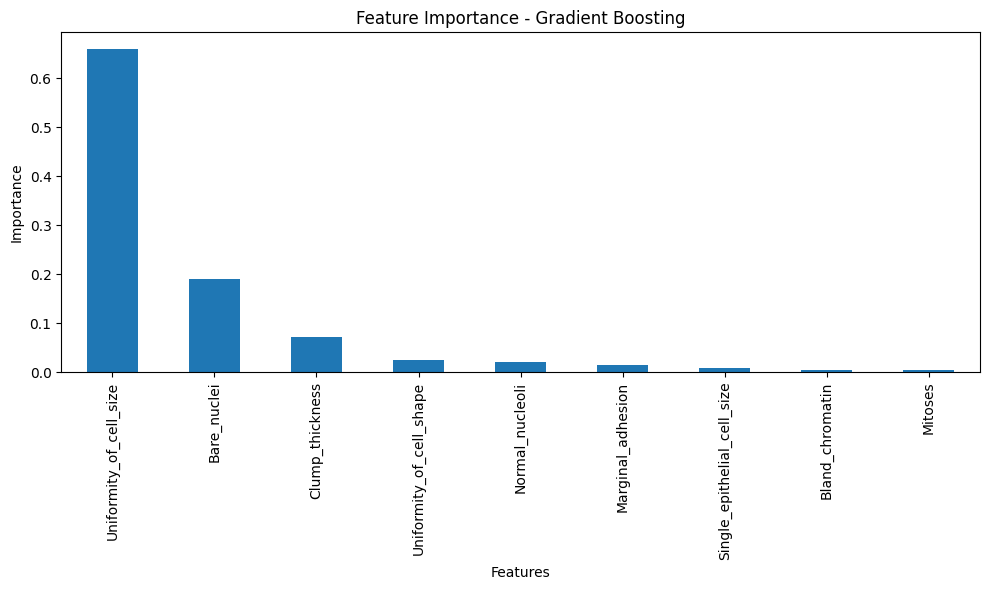

In [15]:
# --- Gradient Boosting Baseline ---
gb_model = GradientBoostingClassifier(random_state=42)
evaluate_model(gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting')


=== AdaBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1038 detik
Waktu Prediksi (Training Set): 0.0142 detik
Waktu Prediksi (Testing Set): 0.0115 detik

Training Performance:
Accuracy: 0.9695
Precision: 0.9657
Recall: 0.9752
F1-Score: 0.9704

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       191
           1       0.97      0.98      0.97       202

    accuracy                           0.97       393
   macro avg       0.97      0.97      0.97       393
weighted avg       0.97      0.97      0.97       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg       0.93     

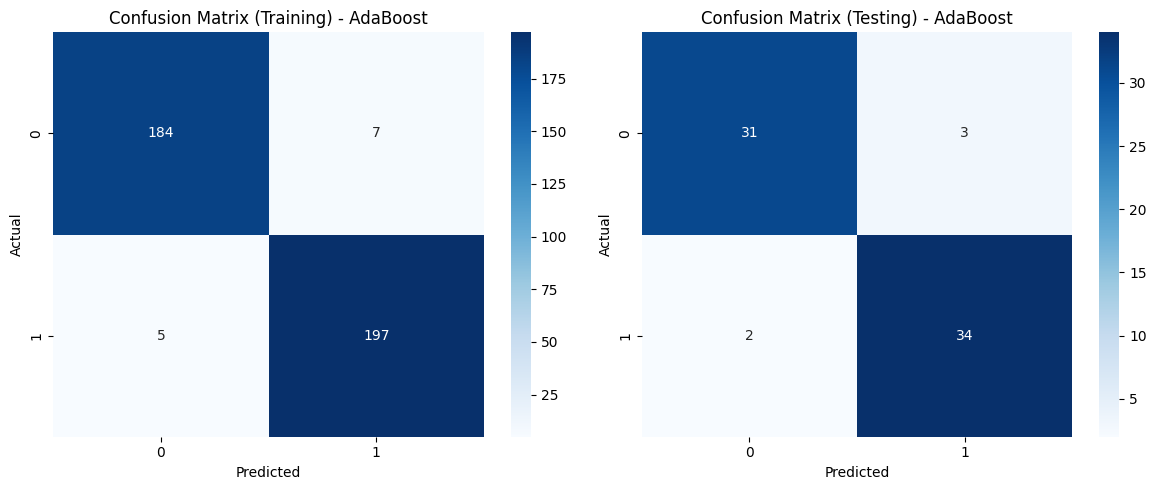

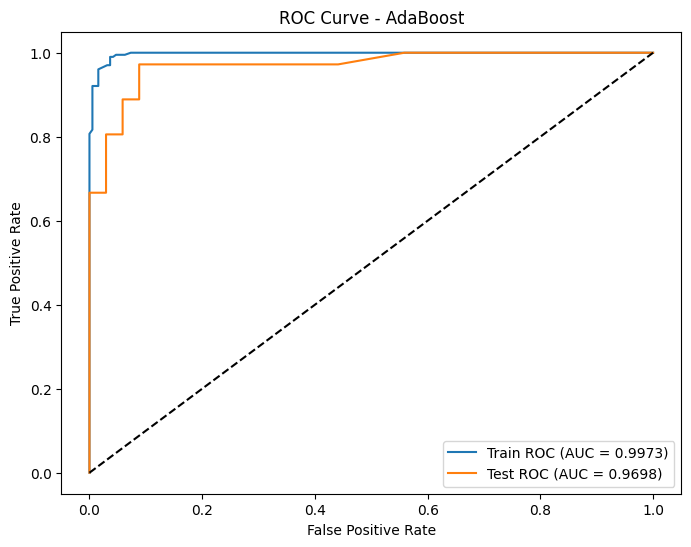

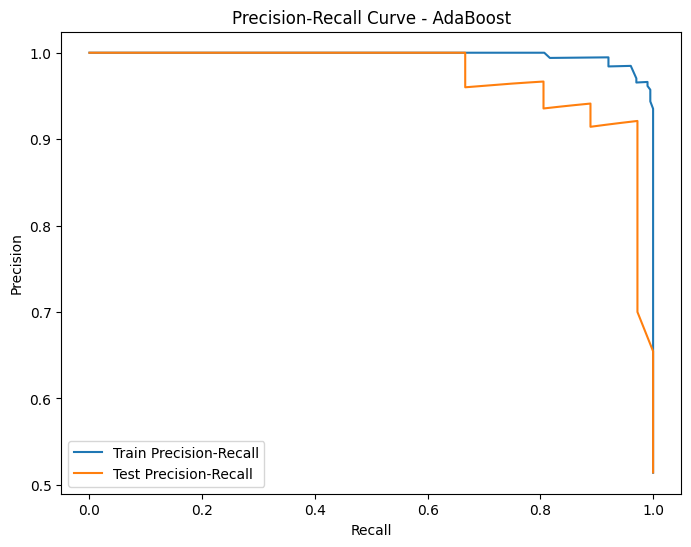

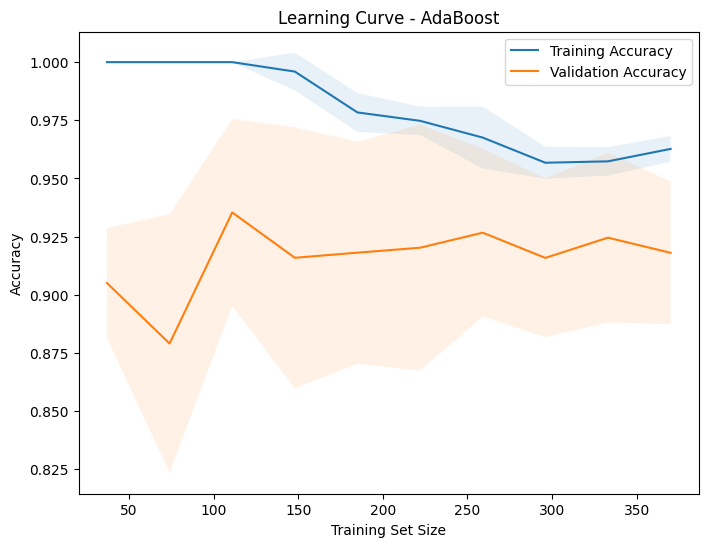


Feature Importance (AdaBoost):
Uniformity_of_cell_size: 0.2556
Bare_nuclei: 0.1910
Clump_thickness: 0.1499
Mitoses: 0.0986
Normal_nucleoli: 0.0980
Marginal_adhesion: 0.0678
Bland_chromatin: 0.0624
Uniformity_of_cell_shape: 0.0601
Single_epithelial_cell_size: 0.0166


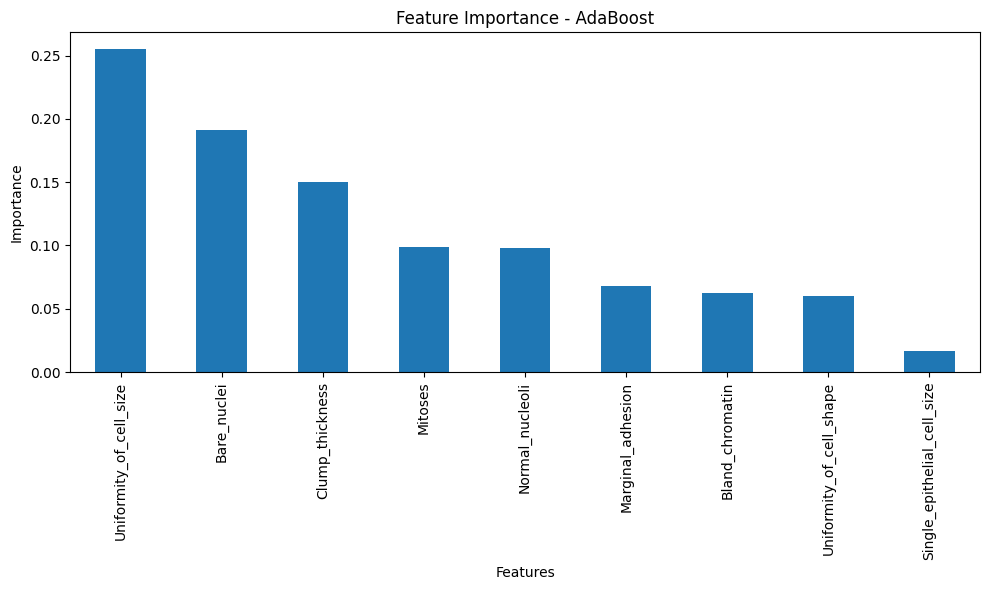

In [16]:
# --- AdaBoost Baseline ---
ada_model = AdaBoostClassifier(random_state=42)
evaluate_model(ada_model, X_train, X_test, y_train, y_test, 'AdaBoost')


=== Extra Trees Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1333 detik
Waktu Prediksi (Training Set): 0.0115 detik
Waktu Prediksi (Testing Set): 0.0089 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       202

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg       0.93  

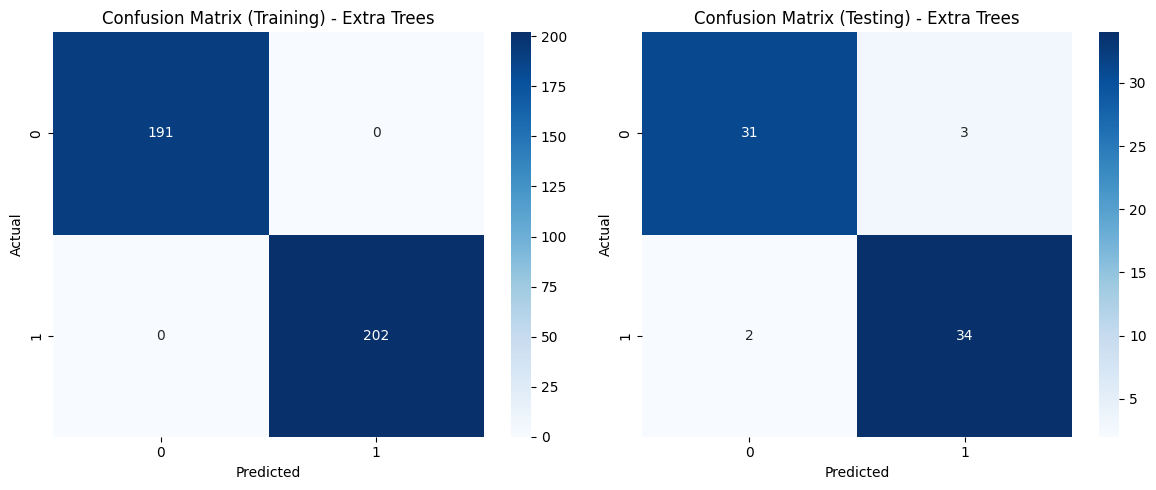

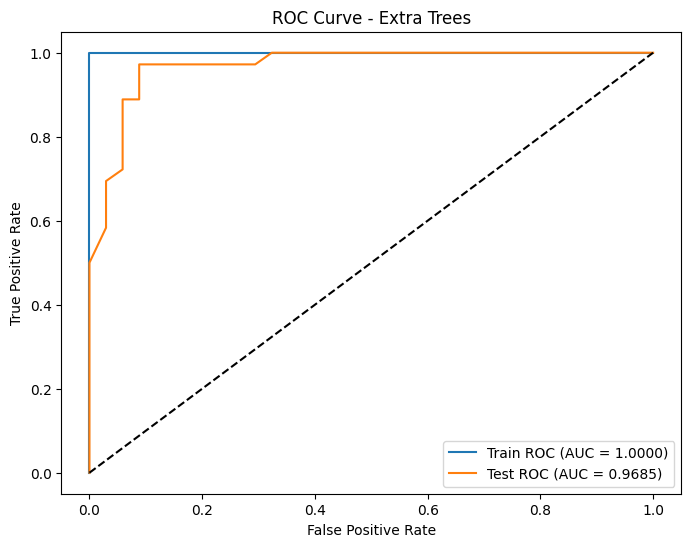

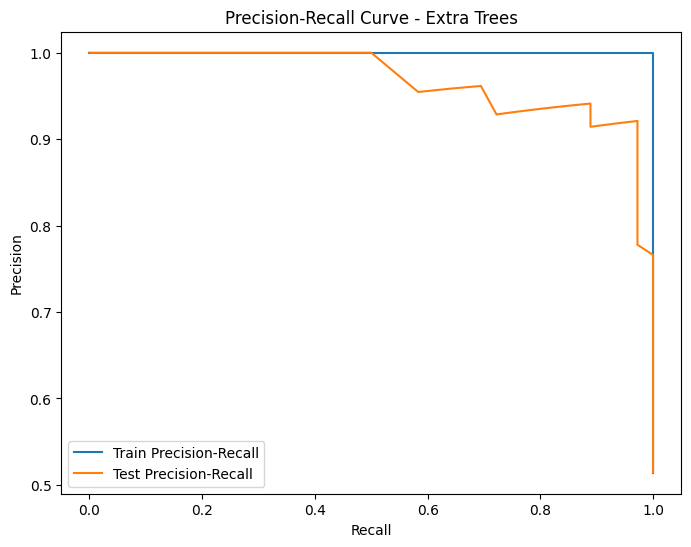

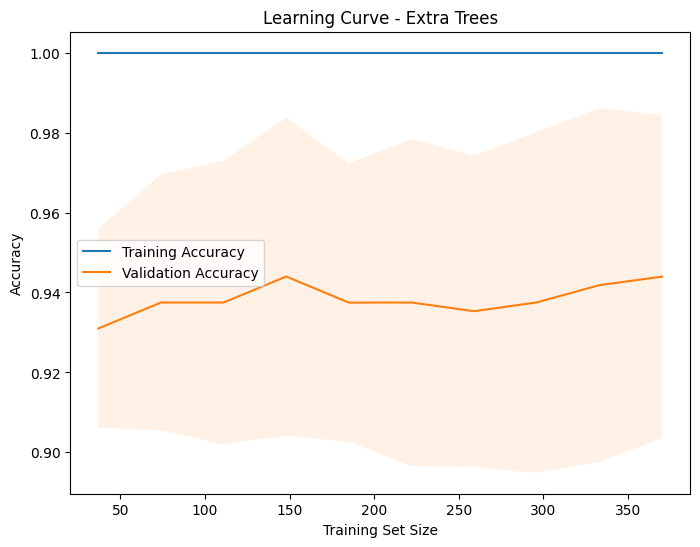


Feature Importance (Extra Trees):
Bare_nuclei: 0.2876
Uniformity_of_cell_size: 0.2031
Uniformity_of_cell_shape: 0.1310
Normal_nucleoli: 0.1034
Clump_thickness: 0.0863
Bland_chromatin: 0.0671
Single_epithelial_cell_size: 0.0612
Marginal_adhesion: 0.0351
Mitoses: 0.0251


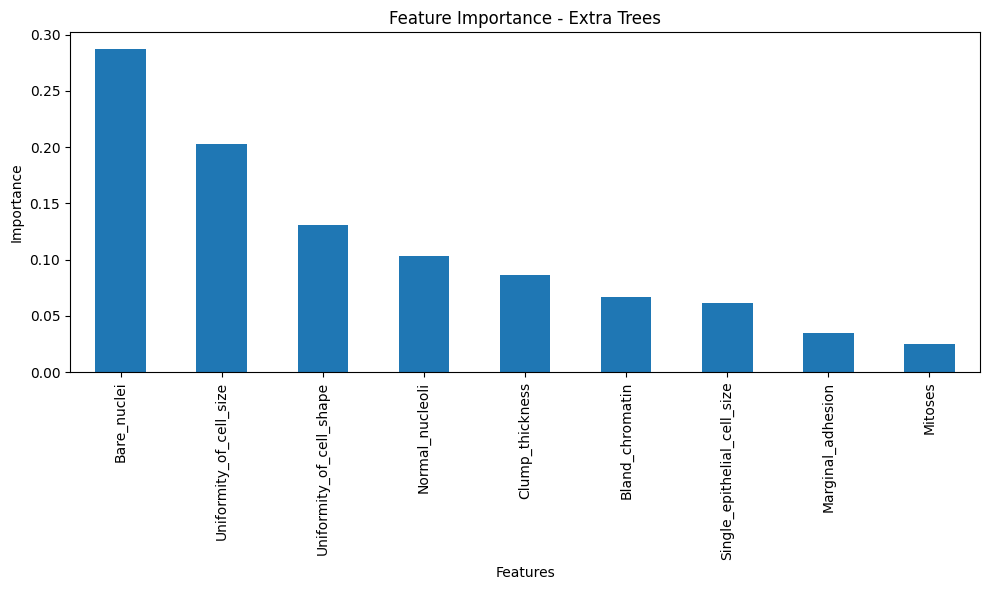

In [17]:
# --- Extra Trees Baseline ---
et_model = ExtraTreesClassifier(random_state=42)
evaluate_model(et_model, X_train, X_test, y_train, y_test, 'Extra Trees')

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0883 detik
Waktu Prediksi (Training Set): 0.0044 detik
Waktu Prediksi (Testing Set): 0.0027 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       202

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393


Testing Performance:
Accuracy: 0.9143
Precision: 0.9167
Recall: 0.9167
F1-Score: 0.9167

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        34
           1       0.92      0.92      0.92        36

    accuracy                           0.91        70
   macro avg       0.91      

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Cross-Validation (5-Fold) Accuracy:
Scores: [0.8387 0.9355 0.9355 0.9348 0.9565]
Mean Accuracy: 0.9202 ± 0.0416


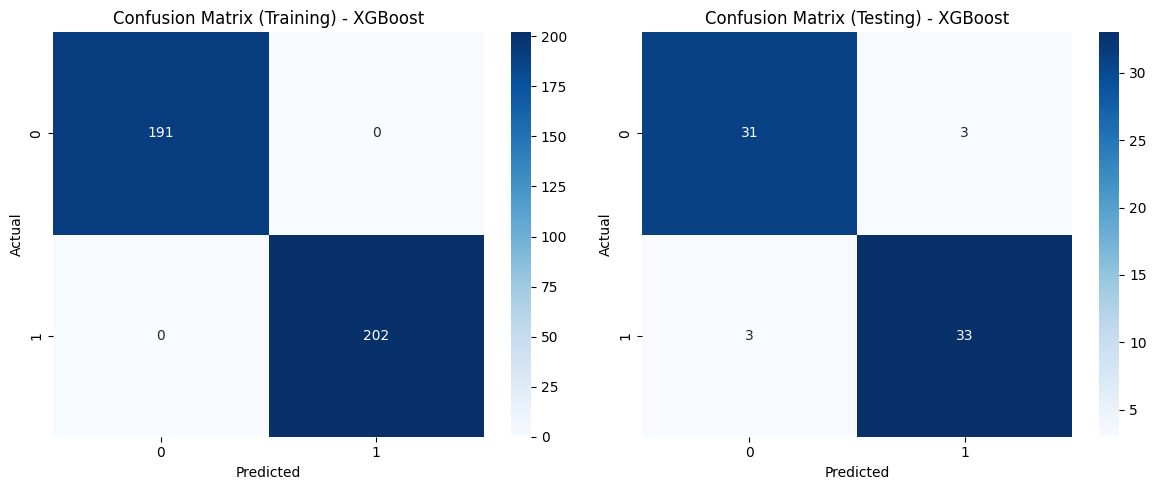

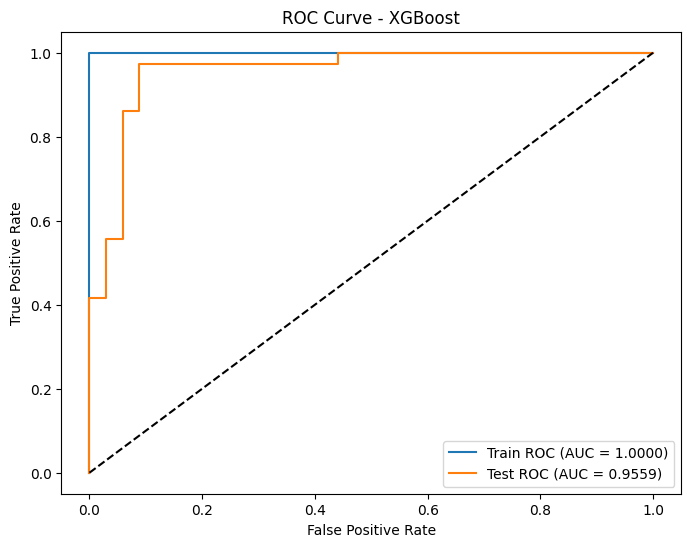

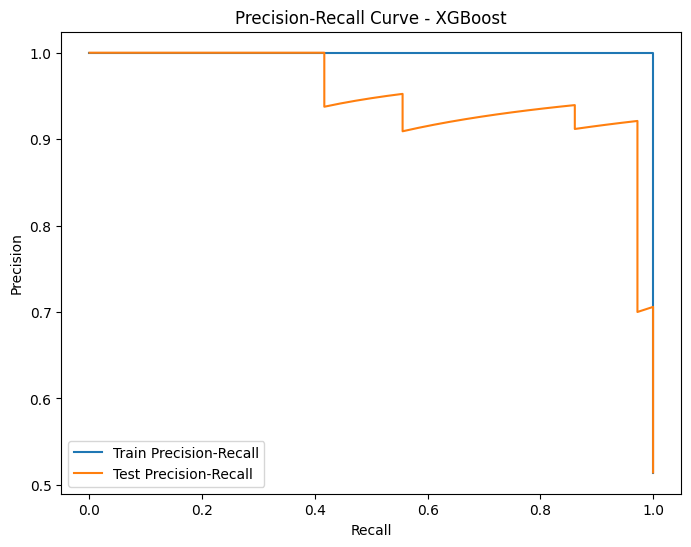

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: U

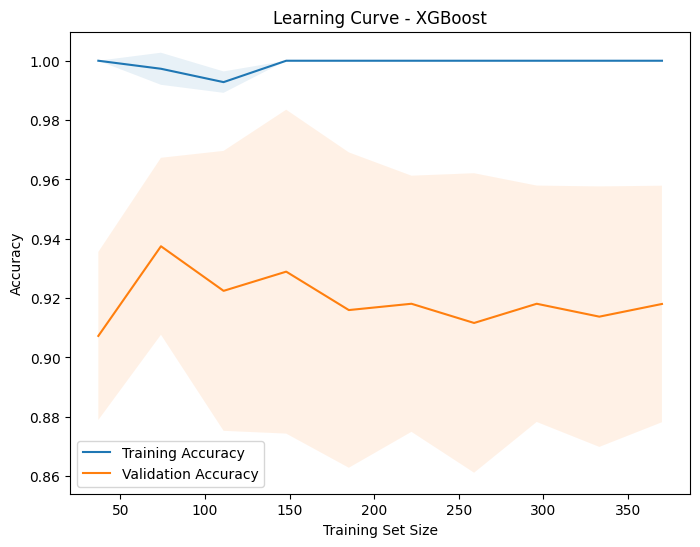


Feature Importance (XGBoost):
Uniformity_of_cell_size: 0.5406
Bare_nuclei: 0.1647
Uniformity_of_cell_shape: 0.0847
Single_epithelial_cell_size: 0.0475
Clump_thickness: 0.0452
Mitoses: 0.0406
Normal_nucleoli: 0.0336
Bland_chromatin: 0.0228
Marginal_adhesion: 0.0203


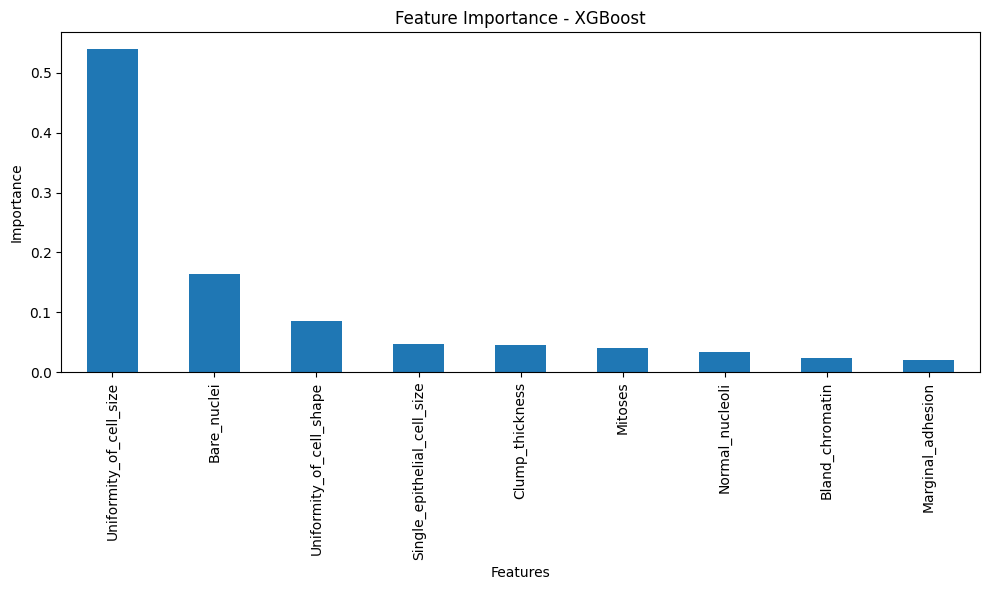

In [18]:
# --- XGBoost Baseline ---
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 'XGBoost')

[LightGBM] [Info] Number of positive: 202, number of negative: 191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 393, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513995 -> initscore=0.055994
[LightGBM] [Info] Start training from score 0.055994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

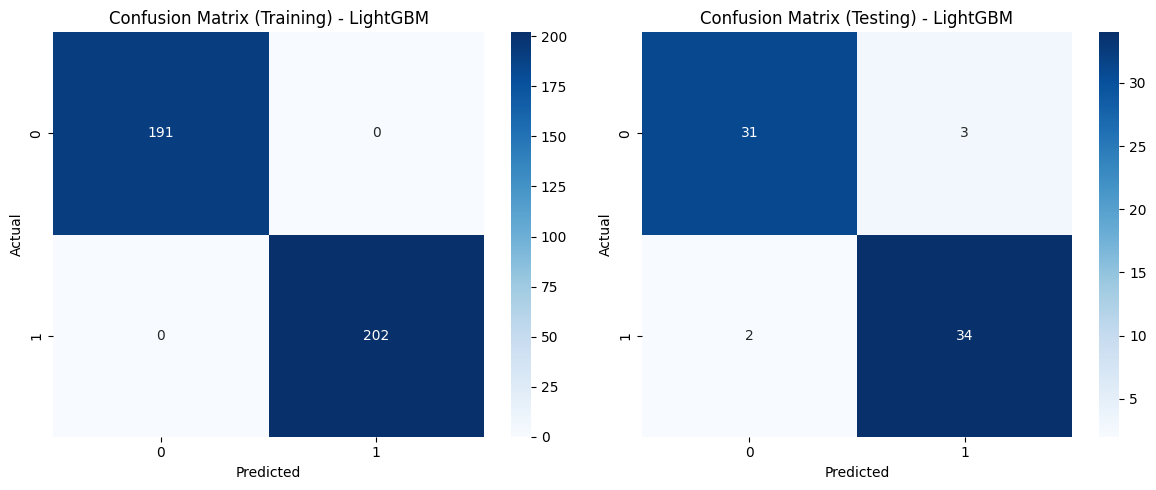

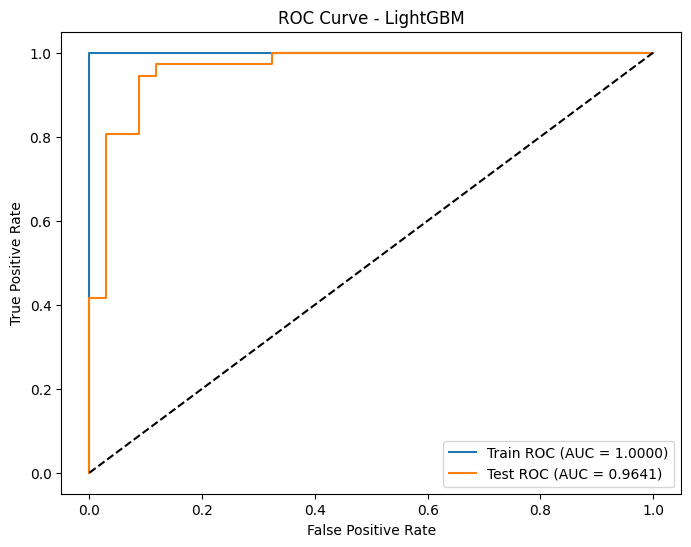

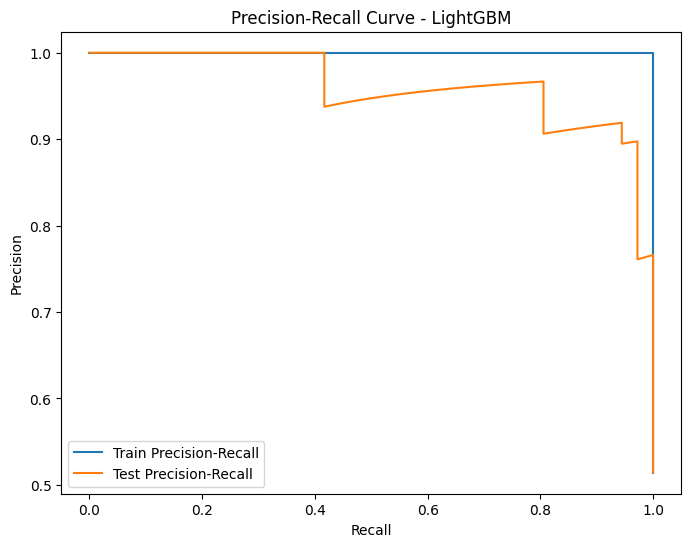

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 16, number of negative: 21
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 37, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432432 -> initscore=-0.271934
[LightGBM] [Info] Start training from score -0.271934
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

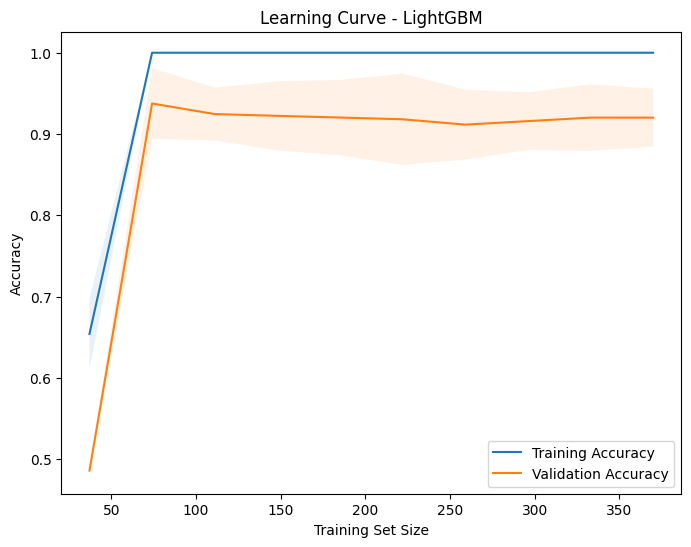


Feature Importance (LightGBM):
Clump_thickness: 351.0000
Bare_nuclei: 308.0000
Uniformity_of_cell_size: 229.0000
Normal_nucleoli: 207.0000
Bland_chromatin: 178.0000
Uniformity_of_cell_shape: 174.0000
Marginal_adhesion: 159.0000
Single_epithelial_cell_size: 114.0000
Mitoses: 51.0000


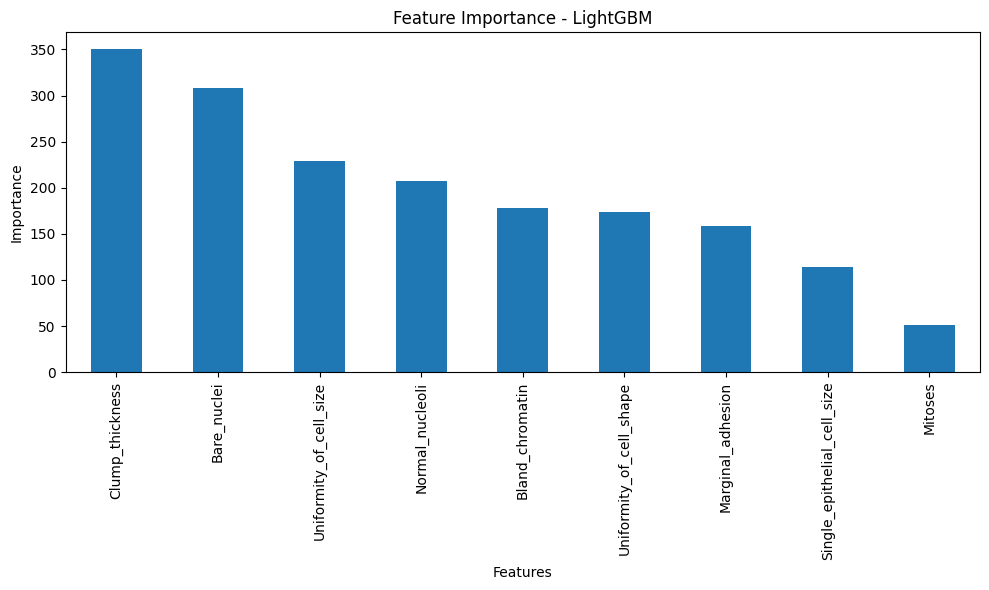

In [19]:
# --- LightGBM Baseline ---
lgb_model = lgb.LGBMClassifier(random_state=42)
evaluate_model(lgb_model, X_train, X_test, y_train, y_test, 'LightGBM')


=== CatBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 1.8174 detik
Waktu Prediksi (Training Set): 0.0059 detik
Waktu Prediksi (Testing Set): 0.0014 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       202

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393


Testing Performance:
Accuracy: 0.9286
Precision: 0.9189
Recall: 0.9444
F1-Score: 0.9315

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.92      0.94      0.93        36

    accuracy                           0.93        70
   macro avg       0.93     

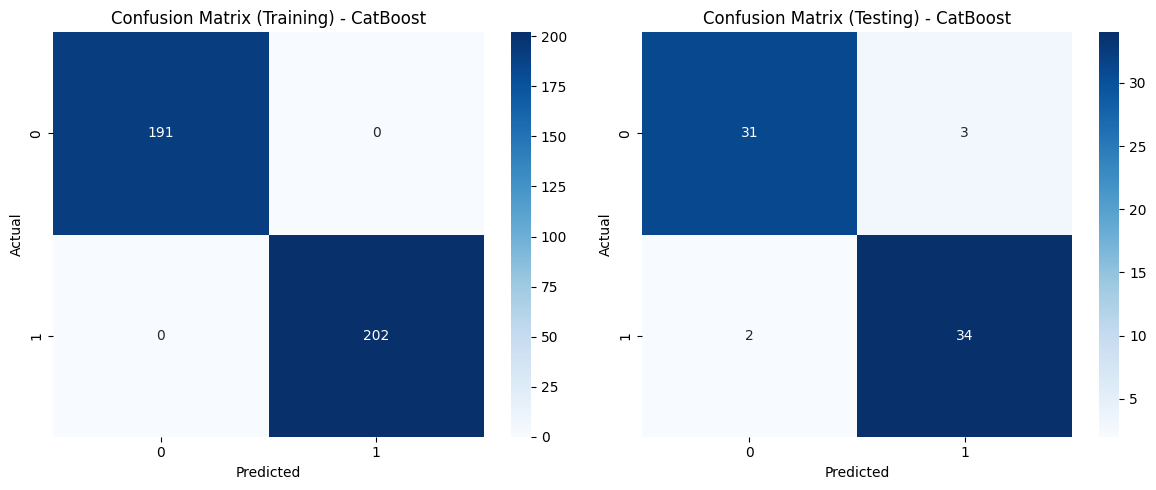

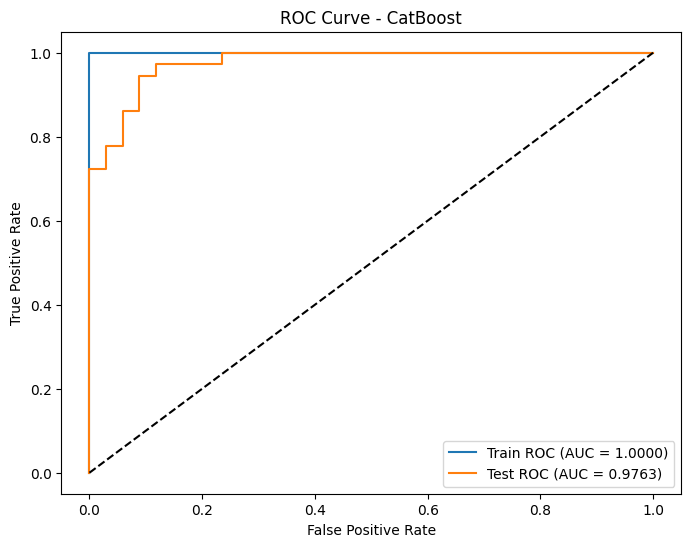

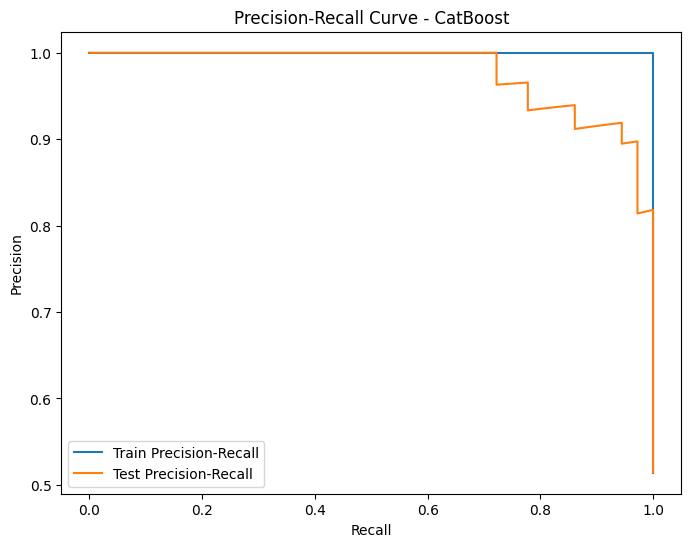

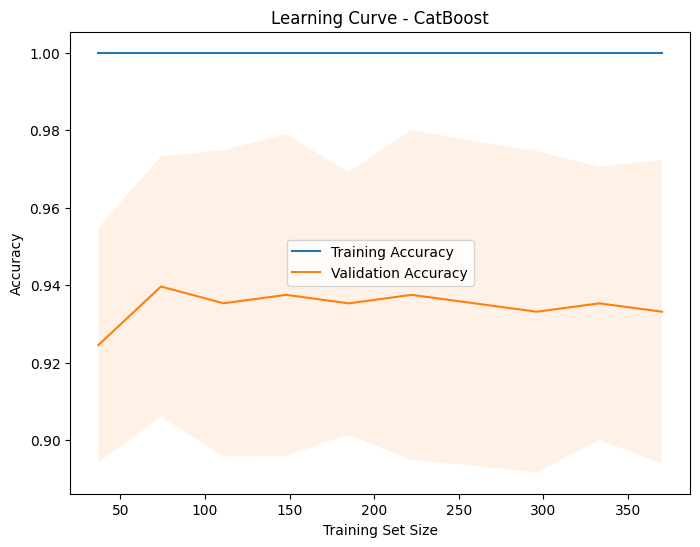


Feature Importance (CatBoost):
Bare_nuclei: 24.6952
Clump_thickness: 14.4410
Uniformity_of_cell_size: 12.1592
Uniformity_of_cell_shape: 10.3365
Normal_nucleoli: 8.9491
Marginal_adhesion: 8.7412
Bland_chromatin: 7.2495
Single_epithelial_cell_size: 7.1361
Mitoses: 6.2921


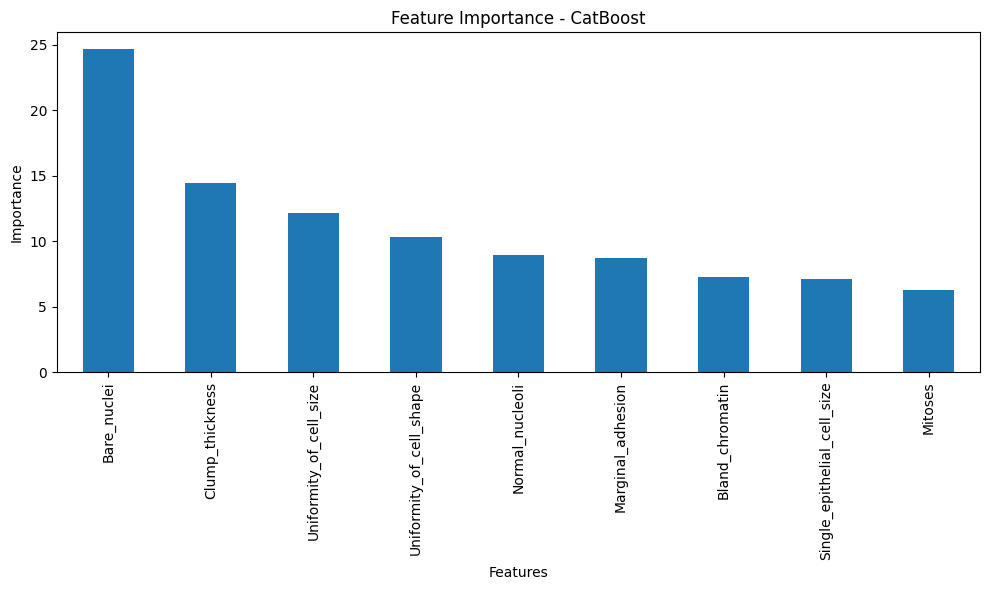

In [20]:
# --- CatBoost Baseline ---
cb_model = cb.CatBoostClassifier(random_state=42, verbose=0)
evaluate_model(cb_model, X_train, X_test, y_train, y_test, 'CatBoost')


=== Neural Network (MLP) Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 1.0855 detik
Waktu Prediksi (Training Set): 0.0007 detik
Waktu Prediksi (Testing Set): 0.0003 detik

Training Performance:
Accuracy: 0.9924
Precision: 0.9901
Recall: 0.9950
F1-Score: 0.9926

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       191
           1       0.99      1.00      0.99       202

    accuracy                           0.99       393
   macro avg       0.99      0.99      0.99       393
weighted avg       0.99      0.99      0.99       393


Testing Performance:
Accuracy: 0.9429
Precision: 0.9444
Recall: 0.9444
F1-Score: 0.9444

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.94      0.94      0.94        36

    accuracy                           0.94        70
   macro avg    

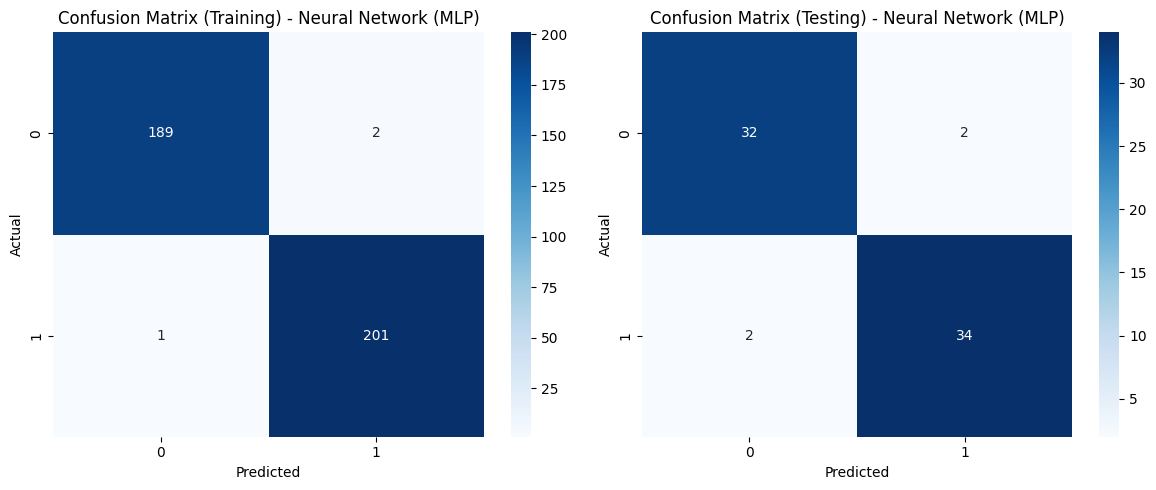

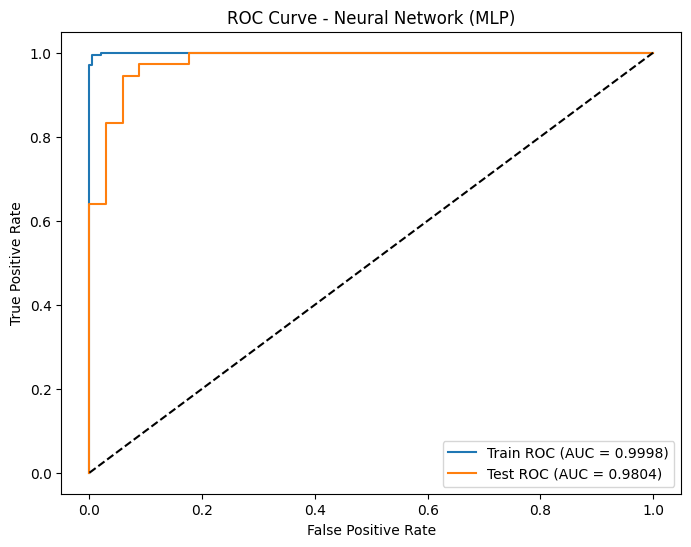

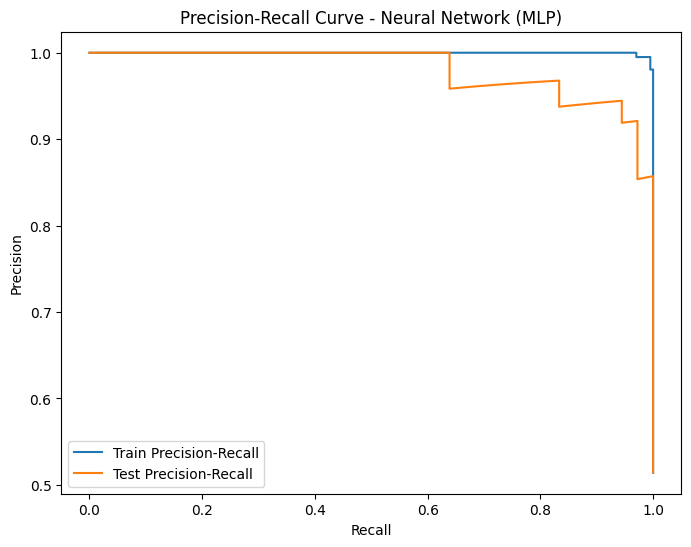

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


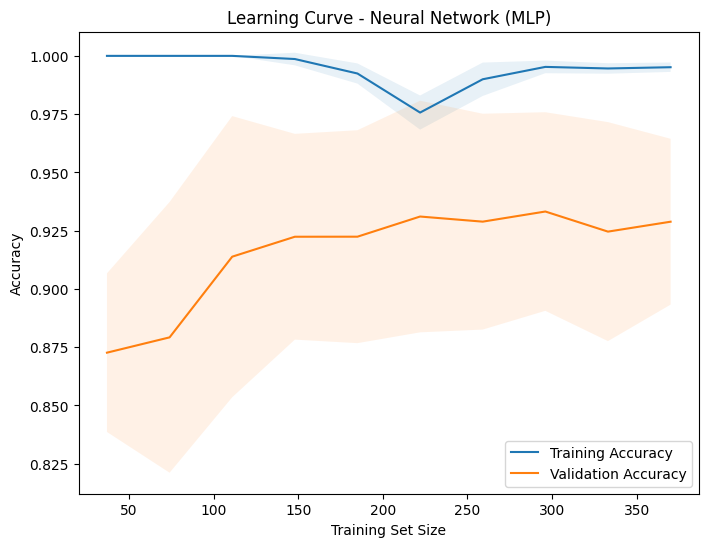

In [21]:
# --- Scale Data for Neural Network ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Neural Network (MLP) Baseline ---
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
evaluate_model(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Neural Network (MLP)')